In [3]:
from simulation import *
from aesthetics import *
from models import *
from data import *

import glob
import os as os
import re as re
import pandas as pd

%reload_ext autoreload
%autoreload 2
%matplotlib inline
mpl.rc('text', usetex=True)

# Scan files

In [4]:
def get_flux(name, cSubstrate=None):
    this = simulation(data_source = 'adk_md_data')
    this.name = name
    this.load = False
    if cSubstrate:
        this.cSubstrate = cSubstrate
    this.simulate(plot=False)
    return np.mean(this.flux_u + this.flux_b), np.std(this.flux_u + this.flux_b), np.mean(this.flux_ub)

In [5]:
def get_power(name, flux, cSubstrate):
    if flux > 0:
        guess = np.random.uniform(low = 0.000001, high = 0.001)
    else:
        guess = np.random.uniform(high = -0.000001, low = -0.001)
    results = sc.optimize.fmin(power_from_load, x0=guess, args=(name, cSubstrate), 
                                 full_output=True, disp=False)
    max_load = results[0][0]
    max_power = -1 *results[1]
    return max_power, max_load

def power_from_load(load, name, cSubstrate):
    this = simulation(data_source = 'adk_md_data')
    this.name = name
    this.load = True
    this.load_slope = load
    if cSubstrate:
        this.cSubstrate = cSubstrate     
    this.simulate()
    flux = np.mean(this.flux_u + this.flux_b)
    power = flux * load
    del this
    return -1 * power

In [7]:
calculation = True
if calculation:
    df = pd.DataFrame()
    adk_dir = '../../md-data/adenylate-kinase/'
    adk_unbound_files = sorted(glob.glob(adk_dir + 'AdKDihedHist_apo-4ake/' + '*'))
    names = []
    for file in range(len(adk_unbound_files)):
        name = os.path.splitext(os.path.basename(adk_unbound_files[file]))[0]
        name = re.search('^[^_]*', name).group(0)        
        if re.search('omega*', name):
            continue
        if re.search('chi3ASN*', name):
            continue
        if re.search('chi5LYS*', name):
            continue
        names.append(name)
        
    for name in names:
        flux, flux_std, intersurface_flux = get_flux(name)
        max_power, max_load = get_power(name, flux, cSubstrate=2*10**-3)

        df = df.append(pd.DataFrame({'Flux': flux,
                                'Flux std': flux_std,
                                'Intersurface flux' : intersurface_flux,
                                'File': name,
                                'Max power': max_power,
                                'Max load' : max_load,
                                'ResID': re.match('.*?([0-9]+)$', name).group(1),
                                }, index=[0]), ignore_index=True)
    df.to_pickle('adk-residues-by-flux.pickle')
else:
    df = pd.read_pickle('adk-residues-by-flux.pickle')

/mnt/639f049e-1c5c-4215-bb93-e396da93aa2b/projects/nonequilibrium/code/SG-model-v2/simulation.py:317: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


In [8]:
# Complicated way of sorting by the flux with catalysis in absolute value.
df.reindex(df['Flux'].abs().order().index)[::-1][0:5]

/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: order is deprecated, use sort_values(...)
  from ipykernel import kernelapp as app


,File,Flux,Flux std,Intersurface flux,Max load,Max power,ResID
332,chi2THR175,-1.200939,0.000177,0.012527,-0.000158,0.013123,175
419,chi3TYR133,-0.998907,0.000098,0.091847,-0.796297,57.001605,133
341,chi2TYR181,-0.636879,0.000228,-0.000002,-0.005256,0.214267,181
446,chi4LYS13,-0.422883,0.000753,0.142975,-0.000260,0.006832,13
314,chi2PHE19,0.380234,0.000233,0.003268,0.000023,0.000768,19


In [11]:
df.reindex(df['Max power'].abs().order().index)[::-1][0:5]

/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: order is deprecated, use sort_values(...)
  if __name__ == '__main__':


,File,Flux,Flux std,Intersurface flux,Max load,Max power,ResID
419,chi3TYR133,-0.998907,0.000098,9.184749e-02,-0.796297,57.001605,133
864,psiSER41,0.054278,0.000045,1.080705e-02,1.046233,15.686298,41
315,chi2PHE81,0.029495,0.001543,-1.003320e-07,0.462943,4.027600,81
557,phiGLY10,0.031143,0.000202,1.900472e-04,0.178573,0.364246,10
341,chi2TYR181,-0.636879,0.000228,-2.332583e-06,-0.005256,0.214267,181


In [13]:
print('The total number of torsions is: {}'.format(len(df)))
print('The number of torsions with flux > 1 is: {}'.format(np.sum(df['Flux'].abs() > 1)))
print('The number of torsions with maximum load > 0.01 is: {}'.format(np.sum(df['Max load'].abs() > 0.01)))
print('The number of torsions with maximum power > 0.01 is: {}'.format(np.sum(df['Max power'].abs() > 0.01)))

The total number of torsions is: 903
The number of torsions with flux > 1 is: 1
The number of torsions with maximum load > 0.01 is: 4
The number of torsions with maximum power > 0.01 is: 14


In [175]:
cSubstrates = []
flux_over_one = []
load_over_point_oh_one = []
max_power_over_point_oh_one = []

max_fluxes = []
max_loads = []
max_powers = []


for concentration in np.arange(-6, 0, 0.1):
    print(concentration)
    df = pd.DataFrame()
    adk_dir = '../../md-data/adenylate-kinase/'
    adk_unbound_files = sorted(glob.glob(adk_dir + 'AdKDihedHist_apo-4ake/' + '*'))
    
    for name in names:
        cSubstrate = 10**concentration
        flux, flux_std = get_flux(name, cSubstrate)
        max_power, max_load = get_power(name, flux, cSubstrate)

        df = df.append(pd.DataFrame({'Flux': flux,
                                'Flux std': flux_std,
                                'File': name,
                                'Max power': max_power,
                                'Max load' : max_load,
                                'ResID': re.match('.*?([0-9]+)$', name).group(1),
                                }, index=[0]), ignore_index=True)
    cSubstrates.append(cSubstrate)
    flux_over_one.append(np.sum(df['Flux'].abs() > 1))
    load_over_point_oh_one.append(np.sum(df['Max load'].abs() > 0.01))
    max_power_over_point_oh_one.append(np.sum(df['Max power'].abs() > 0.01))
    max_fluxes.append(np.max(df['Flux'].abs()))
    max_loads.append(np.max(df['Max load'].abs()))
    max_powers.append(np.max(df['Max power'].abs()))

-6.0
-5.9


/mnt/639f049e-1c5c-4215-bb93-e396da93aa2b/projects/nonequilibrium/code/SG-model-v2/simulation.py:297: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


-5.8
-5.7
-5.6
-5.5
-5.4
-5.3
-5.2
-5.1
-5.0
-4.9
-4.8
-4.7
-4.6
-4.5
-4.4
-4.3
-4.2
-4.1
-4.0
-3.9
-3.8
-3.7
-3.6
-3.5
-3.4
-3.3
-3.2
-3.1
-3.0
-2.9
-2.8
-2.7
-2.6
-2.5
-2.4
-2.3
-2.2
-2.1
-2.0
-1.9
-1.8
-1.7
-1.6
-1.5
-1.4
-1.3
-1.2
-1.1
-1.0
-0.9
-0.8
-0.7
-0.6
-0.5
-0.4
-0.3
-0.2
-0.1


In [216]:
cSubstrates = []
sloshing_over_one = []
max_sloshing = []

for concentration in np.arange(-6, 0, 0.1):
    print(concentration)
    df = pd.DataFrame()
    adk_dir = '../../md-data/adenylate-kinase/'
    adk_unbound_files = sorted(glob.glob(adk_dir + 'AdKDihedHist_apo-4ake/' + '*'))
    
    for name in names:
        cSubstrate = 10**concentration
        this = simulation(data_source = 'adk_md_data')
        this.name = name
        this.load = False
        this.cSubstrate = cSubstrate
        this.simulate(plot=False)
        sloshing = np.mean(this.flux_ub)

        df = df.append(pd.DataFrame({'Sloshing': sloshing,
                                'File': name,
                                'ResID': re.match('.*?([0-9]+)$', name).group(1),
                                }, index=[0]), ignore_index=True)
    cSubstrates.append(cSubstrate)
    sloshing_over_one.append(np.sum(df['Sloshing'].abs() > 1))
    max_sloshing.append(np.max(df['Sloshing'].abs()))


-6.0
-5.9
-5.8
-5.7
-5.6
-5.5
-5.4
-5.3
-5.2
-5.1
-5.0
-4.9
-4.8
-4.7
-4.6
-4.5
-4.4
-4.3
-4.2
-4.1
-4.0
-3.9
-3.8
-3.7
-3.6
-3.5
-3.4
-3.3
-3.2
-3.1
-3.0
-2.9
-2.8
-2.7
-2.6
-2.5
-2.4
-2.3
-2.2
-2.1
-2.0
-1.9
-1.8
-1.7
-1.6
-1.5
-1.4
-1.3
-1.2
-1.1
-1.0
-0.9
-0.8
-0.7
-0.6
-0.5
-0.4
-0.3
-0.2
-0.1


In [186]:
cmap = sns.color_palette("Paired", 10)

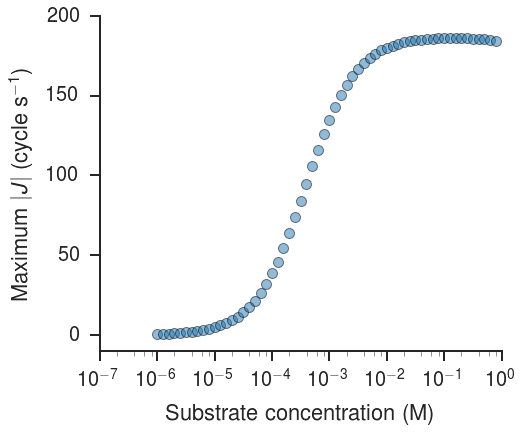

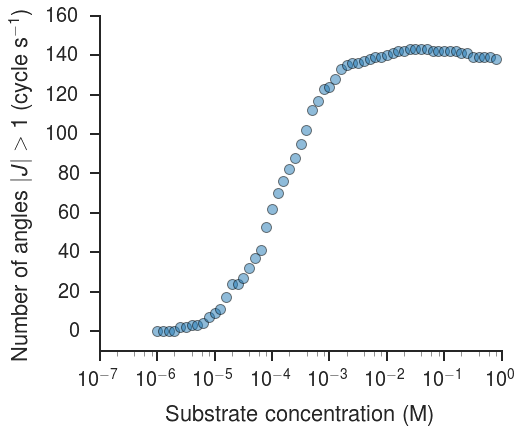

In [194]:
fig = plt.figure(figsize=(6 * 1.2, 6))
gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
ax = plt.subplot(gs[0, 0])
ax.plot(cSubstrates, max_fluxes, 'o', markersize=10, markeredgecolor='k', markeredgewidth=1.0, alpha=0.5, mfc=cmap[1])
ax.set_xlabel('Substrate concentration (M)')
ax.set_ylabel('Maximum $|J|$ (cycle s^{{-1}})')
ax.set_xscale('log')
ax.set_xlim([10**-7, 10**0])
ax.set_ylim([-10, 200])
aesthetics.paper_plot(fig)
plt.savefig('adk-maximum-flux-vs-concentration.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(6 * 1.2, 6))
gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
ax = plt.subplot(gs[0, 0])
ax.plot(cSubstrates, flux_over_one, 'o', markersize=10, markeredgecolor='k', markeredgewidth=1.0, alpha=0.5, mfc=cmap[1])
ax.set_xlabel('Substrate concentration (M)')
ax.set_ylabel('Number of angles $|J| > 1$ (cycle s^{{-1}})')
ax.set_xscale('log')
ax.set_xlim([10**-7, 10**0])
ax.set_ylim([-10, 160])
aesthetics.paper_plot(fig)
plt.savefig('adk-high-flux-vs-concentration.png', dpi=300, bbox_inches='tight')

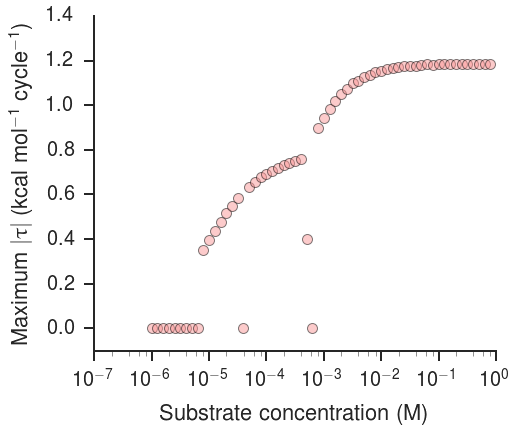

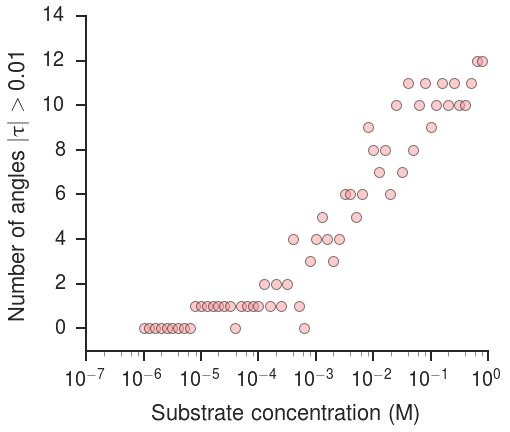

In [210]:
fig = plt.figure(figsize=(6 * 1.2, 6))
gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
ax = plt.subplot(gs[0, 0])
ax.plot(cSubstrates, max_loads, 'o', markersize=10, markeredgecolor='k', markeredgewidth=1.0, alpha=0.5, mfc=cmap[4])
ax.set_xlabel('Substrate concentration (M)')
ax.set_ylabel(r'Maximum $|\tau|$ (kcal mol$^{{-1}}$ cycle$^{{-1}}$)')
ax.set_xscale('log')
ax.set_xlim([10**-7, 10**0])
ax.set_ylim([-0.1, 1.4])
aesthetics.paper_plot(fig)
plt.savefig('adk-maximum-load-vs-concentration.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(6 * 1.2, 6))
gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
ax = plt.subplot(gs[0, 0])
ax.plot(cSubstrates, load_over_point_oh_one, 'o', markersize=10, markeredgecolor='k', markeredgewidth=1.0, alpha=0.5, mfc=cmap[4])
ax.set_xlabel('Substrate concentration (M)')
ax.set_ylabel(r'Number of angles $|\tau| > 0.01$', multialignment='center')
ax.set_xscale('log')
ax.set_xlim([10**-7, 10**0])
ax.set_ylim([-1, 14])
aesthetics.paper_plot(fig)
plt.savefig('adk-high-load-vs-concentration.png', dpi=300, bbox_inches='tight')

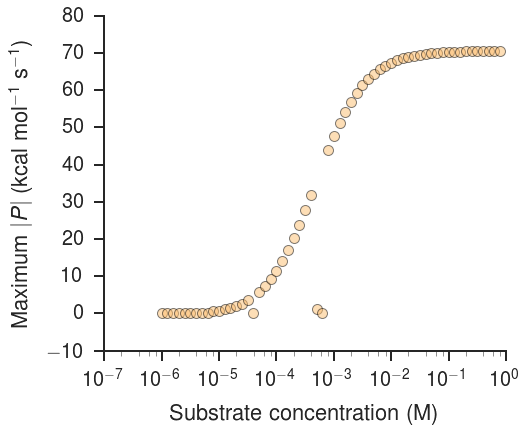

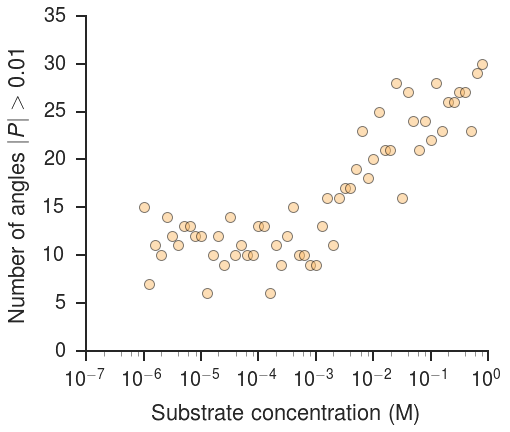

In [215]:
fig = plt.figure(figsize=(6 * 1.2, 6))
gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
ax = plt.subplot(gs[0, 0])
ax.plot(cSubstrates, max_powers, 'o', markersize=10, markeredgecolor='k', markeredgewidth=1.0, alpha=0.5, mfc=cmap[6])
ax.set_xlabel('Substrate concentration (M)')
ax.set_ylabel(r'Maximum $|P|$ (kcal mol$^{{-1}}$ s$^{{-1}}$)')
ax.set_xscale('log')
ax.set_xlim([10**-7, 10**0])
ax.set_ylim([-10, 80])
aesthetics.paper_plot(fig)
plt.savefig('adk-maximum-power-vs-concentration.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(6 * 1.2, 6))
gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
ax = plt.subplot(gs[0, 0])
ax.plot(cSubstrates, max_power_over_point_oh_one, 'o', markersize=10, markeredgecolor='k', markeredgewidth=1.0, 
        alpha=0.5, mfc=cmap[6])
ax.set_xlabel('Substrate concentration (M)')
ax.set_ylabel(r'Number of angles $|P| > 0.01$', multialignment='center')
ax.set_xscale('log')
ax.set_xlim([10**-7, 10**0])
ax.set_ylim([-0, 35])
aesthetics.paper_plot(fig)
plt.savefig('adk-high-power-vs-concentration.png', dpi=300, bbox_inches='tight')

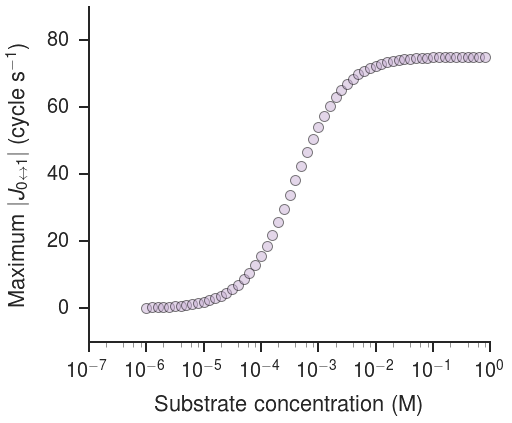

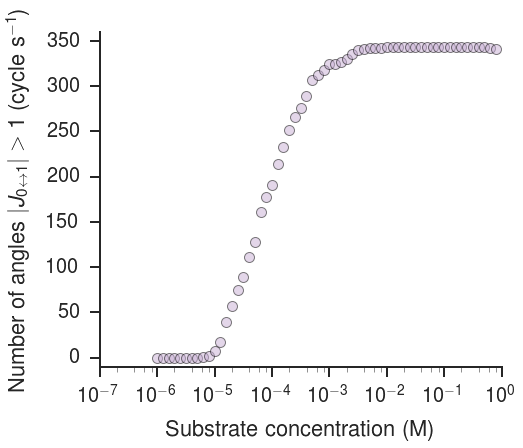

In [221]:
fig = plt.figure(figsize=(6 * 1.2, 6))
gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
ax = plt.subplot(gs[0, 0])
ax.plot(cSubstrates, max_sloshing, 'o', markersize=10, markeredgecolor='k', markeredgewidth=1.0, alpha=0.5, mfc=cmap[8])
ax.set_xlabel('Substrate concentration (M)')
ax.set_ylabel('Maximum $|J_{0 \leftrightarrow 1}|$ (cycle s^{{-1}})')
ax.set_xscale('log')
ax.set_xlim([10**-7, 10**0])
ax.set_ylim([-10, 90])
aesthetics.paper_plot(fig)
plt.savefig('adk-maximum-sloshing-vs-concentration.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(6 * 1.2, 6))
gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
ax = plt.subplot(gs[0, 0])
ax.plot(cSubstrates, sloshing_over_one, 'o', markersize=10, markeredgecolor='k', markeredgewidth=1.0, alpha=0.5, 
        mfc=cmap[8])
ax.set_xlabel('Substrate concentration (M)')
ax.set_ylabel('Number of angles $|J_{0 \leftrightarrow 1}| > 1$ (cycle s^{{-1}})')
ax.set_xscale('log')
ax.set_xlim([10**-7, 10**0])
ax.set_ylim([-10, 360])
aesthetics.paper_plot(fig)
plt.savefig('adk-high-sloshing-vs-concentration.png', dpi=300, bbox_inches='tight')

# Let's encode all this data in a dataframe...
This is so we can look at particular files later on.

In [243]:
cSubstrates = []

df = pd.DataFrame()

for concentration in np.arange(0, 6.0, 0.4):
    print('Concentration = {}'.format(concentration))
    adk_dir = '../../md-data/adenylate-kinase/'
    adk_unbound_files = sorted(glob.glob(adk_dir + 'AdKDihedHist_apo-4ake/' + '*'))
    
    for name in names:
        cSubstrate = 10**-concentration
        flux, flux_std, sloshing = get_flux(name, cSubstrate)
        max_power, max_load = get_power(name, flux, cSubstrate)
        
        df = df.append(pd.DataFrame({'Flux': flux,
                                'Concentration': concentration,
                                'File': name,
                                'Max power': max_power,
                                'Max load' : max_load,
                                'Sloshing' : sloshing,
                                'ResID': re.match('.*?([0-9]+)$', name).group(1),
                                }, index=[0]), ignore_index=True)

Concentration = 0.0


/mnt/639f049e-1c5c-4215-bb93-e396da93aa2b/projects/nonequilibrium/code/SG-model-v2/simulation.py:297: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


Concentration = 0.4
Concentration = 0.8
Concentration = 1.2000000000000002
Concentration = 1.6
Concentration = 2.0
Concentration = 2.4000000000000004
Concentration = 2.8000000000000003
Concentration = 3.2
Concentration = 3.6
Concentration = 4.0
Concentration = 4.4
Concentration = 4.800000000000001
Concentration = 5.2
Concentration = 5.6000000000000005


In [3]:
# Save the pickle!
save = False
if save:
    df.to_pickle('adk-by-concentration.pickle')
else:
    df = pd.read_pickle('adk-by-concentration.pickle')

In [11]:
df[df['File'] == 'chi1SER30']

,Concentration,File,Flux,Max load,Max power,ResID,Sloshing
154,0.0,chi1SER30,-8.417728,-2.026448e-05,1.230895e-04,30,-45.365797
1057,0.4,chi1SER30,-9.377873,-2.902576e-05,1.747509e-04,30,-46.116670
1960,0.8,chi1SER30,-9.774417,-3.599083e-05,2.018608e-04,30,-46.373132
2863,1.2,chi1SER30,-9.905521,-2.863135e-05,1.885842e-04,30,-46.333994
3766,1.6,chi1SER30,-9.883122,-4.630553e-05,2.079578e-04,30,-45.963041
4669,2.0,chi1SER30,-9.687235,-2.968273e-05,1.838750e-04,30,-44.952993
5572,2.4,chi1SER30,-9.179991,-7.559988e-05,5.220334e-06,30,-42.564273
6475,2.8,chi1SER30,-8.099542,-3.133552e-05,1.296045e-04,30,-37.540417
7378,3.2,chi1SER30,-6.247897,-3.398754e-05,5.445739e-05,30,-28.952946
8281,3.6,chi1SER30,-3.968351,3.252607e-18,-1.290749e-17,30,-18.387164


In [139]:
df[df['Concentration'] == df['Concentration'].min()].sort('Max power')[::-1][0:5]

/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Concentration,File,Flux,Max load,Max power,ResID,Sloshing
419,0.0,chi3TYR133,-157.325574,-0.813251,70.460649,133,14.464721
864,0.0,psiSER41,89.488016,1.185096,52.786130,41,17.811927
315,0.0,chi2PHE81,64.728799,0.487091,15.924887,81,0.006267
559,0.0,phiGLY12,40.751089,0.471844,9.400455,12,0.514491
690,0.0,psiALA11,21.025453,0.208485,2.142465,11,5.274683


In [145]:
for concentration in np.arange(0, 6.0, 0.4):
    print(df[df['Concentration'] == concentration].sort('Max power')[::-1][0:1])



     Concentration        File        Flux  Max load  Max power ResID  \
419            0.0  chi3TYR133 -157.325574 -0.813251  70.460649   133   

      Sloshing  
419  14.464721  
      Concentration        File        Flux  Max load  Max power ResID  \
1322            0.4  chi3TYR133 -157.364569 -0.814948  70.497961   133   

       Sloshing  
1322  14.468611  
      Concentration        File        Flux  Max load  Max power ResID  \
2225            0.8  chi3TYR133 -157.184287 -0.816061  70.405528   133   

       Sloshing  
2225  14.452054  
      Concentration        File        Flux  Max load  Max power ResID  \
3128            1.2  chi3TYR133 -156.620504  -0.81535  70.100644   133   

       Sloshing  
3128  14.400364  
      Concentration        File        Flux  Max load  Max power ResID  \
4031            1.6  chi3TYR133 -155.182121 -0.813097  69.319188   133   

       Sloshing  
4031  14.267971  
      Concentration        File       Flux  Max load  Max power ResID  \
4934  

/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


Concentration = 0.0


/mnt/639f049e-1c5c-4215-bb93-e396da93aa2b/projects/nonequilibrium/code/SG-model-v2/simulation.py:317: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


Concentration = 0.2
Concentration = 0.4
Concentration = 0.6000000000000001
Concentration = 0.8
Concentration = 1.0
Concentration = 1.2000000000000002
Concentration = 1.4000000000000001
Concentration = 1.6
Concentration = 1.8
Concentration = 2.0
Concentration = 2.2
Concentration = 2.4000000000000004
Concentration = 2.6
Concentration = 2.8000000000000003
Concentration = 3.0
Concentration = 3.2
Concentration = 3.4000000000000004
Concentration = 3.6
Concentration = 3.8000000000000003
Concentration = 4.0
Concentration = 4.2
Concentration = 4.4
Concentration = 4.6000000000000005
Concentration = 4.800000000000001
Concentration = 5.0
Concentration = 5.2
Concentration = 5.4
Concentration = 5.6000000000000005
Concentration = 5.800000000000001


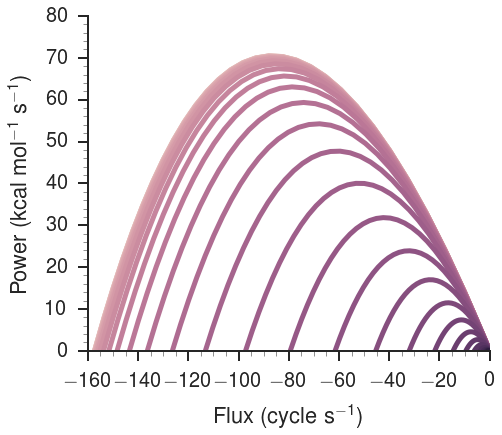

In [112]:
fig = plt.figure(figsize=(6 * 1.2, 6))
gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
ax = plt.subplot(gs[0, 0])
concentrations = np.arange(0, 6, 0.2)
loads = np.arange(0.001, 2, 0.05)
cmap = sns.cubehelix_palette(len(concentrations))

# This little hack helps with the colorbar
all_fluxes = np.zeros((len(concentrations), len(loads)))
all_powers = np.zeros((len(concentrations), len(loads)))

chi3TYR133 = pd.DataFrame()

for concentration in concentrations:
    print('Concentration = {}'.format(concentration))
    name = 'chi3TYR133'
    cSubstrate = 10**-concentration
    this = simulation(data_source = 'adk_md_data')
    this.name = name
    this.cSubstrate = cSubstrate
    fluxes = []
    powers = []
    for load in loads:
        this.load = True
        this.load_slope = -load
        this.simulate()
        
        all_fluxes[np.where(concentrations == concentration)[0], 
                  np.where(loads == load)[0]] = np.mean(this.flux_u + this.flux_b)
        all_powers[np.where(concentrations == concentration)[0], 
                  np.where(loads == load)[0]] = -load * np.mean(this.flux_u + this.flux_b)
        
        chi3TYR133 = chi3TYR133.append(pd.DataFrame({'Flux': np.mean(this.flux_u + this.flux_b),
                        'Power': -load * np.mean(this.flux_u + this.flux_b),
                        'Concentration' : 10**-concentration,
                        }, index=[0]), ignore_index=True)
# ax.legend()

for i in range(len(concentrations)):
    ax.plot(all_fluxes[i], all_powers[i], c=cmap[i])


ax.set_ylim([0, 80])
ax.set_xlim([-160, 0])
aesthetics.paper_plot(fig)
ax.set_ylabel(r'Power (kcal mol$^{{-1}}$ s$^{{-1}}$)')
ax.set_xlabel('Flux (cycle s$^{{-1}}$)')

Concentration = 0.0


/mnt/639f049e-1c5c-4215-bb93-e396da93aa2b/projects/nonequilibrium/code/SG-model-v2/simulation.py:317: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


Concentration = 0.2
Concentration = 0.4
Concentration = 0.6000000000000001
Concentration = 0.8
Concentration = 1.0
Concentration = 1.2000000000000002
Concentration = 1.4000000000000001
Concentration = 1.6
Concentration = 1.8
Concentration = 2.0
Concentration = 2.2
Concentration = 2.4000000000000004
Concentration = 2.6
Concentration = 2.8000000000000003
Concentration = 3.0
Concentration = 3.2
Concentration = 3.4000000000000004
Concentration = 3.6
Concentration = 3.8000000000000003
Concentration = 4.0
Concentration = 4.2
Concentration = 4.4
Concentration = 4.6000000000000005
Concentration = 4.800000000000001
Concentration = 5.0
Concentration = 5.2
Concentration = 5.4
Concentration = 5.6000000000000005
Concentration = 5.800000000000001


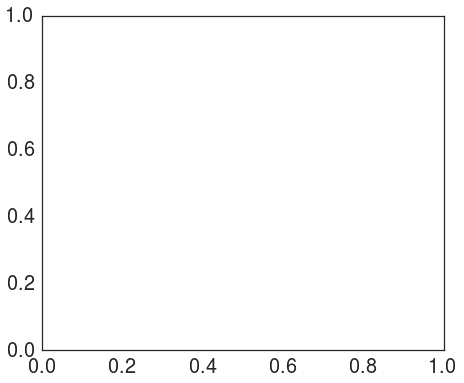

In [136]:
concentrations = np.arange(0, 6, 0.2)
loads = np.arange(0.001, 2, 0.05)
cmap = sns.cubehelix_palette(len(concentrations))

# This little hack helps with the colorbar
all_fluxes = np.zeros((len(concentrations), len(loads)))
all_powers = np.zeros((len(concentrations), len(loads)))

psiSER41 = pd.DataFrame()

for concentration in concentrations:
    print('Concentration = {}'.format(concentration))
    name = 'psiSER41'
    cSubstrate = 10**-concentration
    this = simulation(data_source = 'adk_md_data')
    this.name = name
    this.cSubstrate = cSubstrate
    fluxes = []
    powers = []
    for load in loads:
        this.load = True
        this.load_slope = load
        this.simulate()
        
        all_fluxes[np.where(concentrations == concentration)[0], 
                  np.where(loads == load)[0]] = np.mean(this.flux_u + this.flux_b)
        all_powers[np.where(concentrations == concentration)[0], 
                  np.where(loads == load)[0]] = load * np.mean(this.flux_u + this.flux_b)
        
        psiSER41 = psiSER41.append(pd.DataFrame({'Flux': np.mean(this.flux_u + this.flux_b),
                        'Power': -load * np.mean(this.flux_u + this.flux_b),
                        'Concentration' : 10**-concentration,
                        }, index=[0]), ignore_index=True)

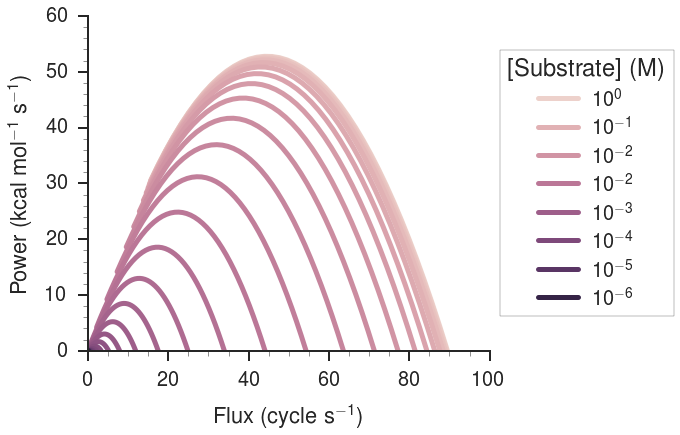

In [196]:
fig = plt.figure(figsize=(6 * 1.2, 6))
gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
ax = plt.subplot(gs[0, 0])

for i in range(len(concentrations)):
    ax.plot(all_fluxes[i], all_powers[i], c=cmap[i], label='$10^{{{0:0.0f} }}$'.format(-1*concentrations[i] if concentrations[i] > 0 else concentrations[i]) 
            if i%4==0 else None)
    # ax.scatter(all_fluxes[i], all_powers[i], s=40, facecolor='none', edgecolor='k', zorder=10)

ax.set_ylim([0, 60])
ax.set_xlim([0, 100])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True, title='[Substrate] (M)')
# legend = plt.legend(bbox_to_anchor=(0., 1.02, 1., 0.), handletextpad=0.3,
#                     loc='lower left', ncol=6, mode="expand", borderaxespad=0,
#                     numpoints=1, handlelength=0.5)

aesthetics.paper_plot(fig)
ax.set_ylabel(r'Power (kcal mol$^{{-1}}$ s$^{{-1}}$)')
ax.set_xlabel('Flux (cycle s$^{{-1}}$)')


## Spot check

Let's look at the 10 highest power angles and see if the "optimized" value makese sense. When we do a random spot check, some angles report maximum power very, very low (say, on the order of 10^(-20)) and scanning that region gets messy and doesn't behave.

In [39]:
df[df['File'] == 'chi1PRO27']

,File,Flux,Flux std,Max load,Max power,ResID
148,chi1PRO27,0.000332,0.005059,-5.157323e-07,0.00105,27


# Using a pseudo-bimolecular on rate constant, the effective substrate concentration is about 1000x lower than before.

C                         +8.33e+10  second**-1
D                         +3.00e+12  degrees**2 second**-1
k_{cat}                   +3.12e+02  second**-1
[S]                       +2.50e-06  M         
dt                        +1.00e-12  second**-1
-----------------         ---------  --------- 
Intrasurface flux         -9.99e-01  cycle second**-1
Intersurface flux         +9.18e-02  cycle second**-1


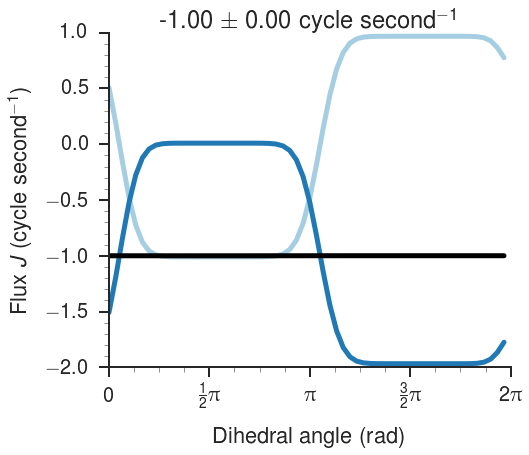

In [40]:
this = simulation(data_source='adk_md_data')
this.name = 'chi3TYR133'
this.simulate()
this.plot_flux()

# I can recapitulate the results presented last week

C                         +8.33e+10  second**-1
D                         +3.00e+12  degrees**2 second**-1
k_{cat}                   +3.12e+02  second**-1
[S]                       +2.00e-03  M         
dt                        +1.00e-12  second**-1
-----------------         ---------  --------- 
Intrasurface flux         -1.32e+02  cycle second**-1
Intersurface flux         +1.21e+01  cycle second**-1


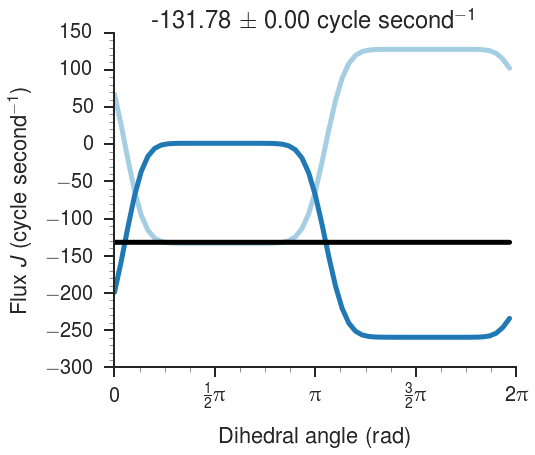

In [38]:
this = simulation(data_source='adk_md_data')
this.name = 'chi3TYR133'
this.cSubstrate = 2*10**-3
this.simulate()
this.plot_flux()

# Now, with an applied load...

C                         +8.33e+10  second**-1
D                         +3.00e+12  degrees**2 second**-1
k_{cat}                   +3.12e+02  second**-1
[S]                       +2.50e-06  M         
dt                        +1.00e-12  second**-1
-----------------         ---------  --------- 
Intrasurface flux         -6.97e-01  cycle second**-1
Intersurface flux         +8.95e-02  cycle second**-1
-----------------         ---------  --------- 
Applied load              -1.00e-01  kcal mol**-1 cycle**-1
Power                     +6.97e-02  kcal mol**-1 second**-1


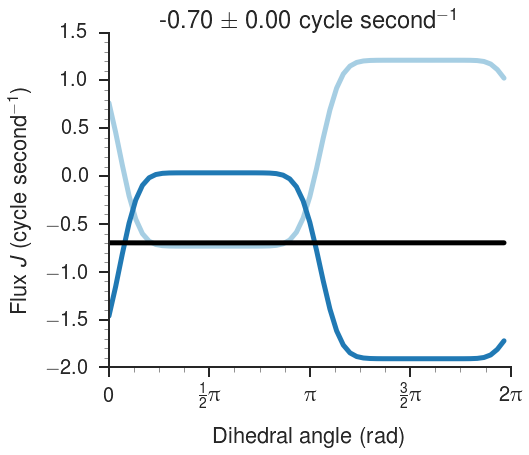

In [43]:
this = simulation(data_source='adk_md_data')
this.name = 'chi3TYR133'
this.load = True
this.load_slope = -0.1
this.simulate()
this.plot_flux()

# And earlier, with an applied load of the same magnitude

C                         +8.33e+10  second**-1
D                         +3.00e+12  degrees**2 second**-1
k_{cat}                   +3.12e+02  second**-1
[S]                       +2.00e-03  M         
dt                        +1.00e-12  second**-1
-----------------         ---------  --------- 
Intrasurface flux         -1.25e+02  cycle second**-1
Intersurface flux         +1.20e+01  cycle second**-1
-----------------         ---------  --------- 
Applied load              -1.00e-01  kcal mol**-1 cycle**-1
Power                     +1.25e+01  kcal mol**-1 second**-1


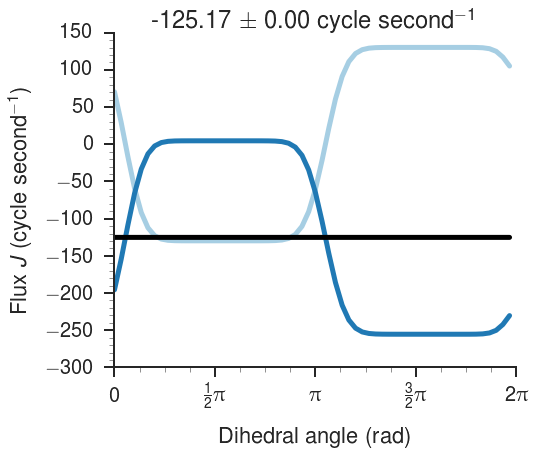

In [46]:
this = simulation(data_source='adk_md_data')
this.name = 'chi3TYR133'
this.cSubstrate = 2*10**-3
this.load = True
this.load_slope = -0.1
this.simulate()
this.plot_flux()

# Let's write a scan to show power as a function of load

/mnt/639f049e-1c5c-4215-bb93-e396da93aa2b/projects/nonequilibrium/code/SG-model-v2/simulation.py:297: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


(-2.0, 0)

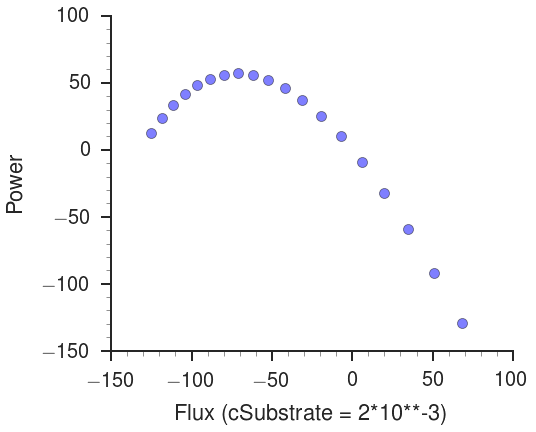

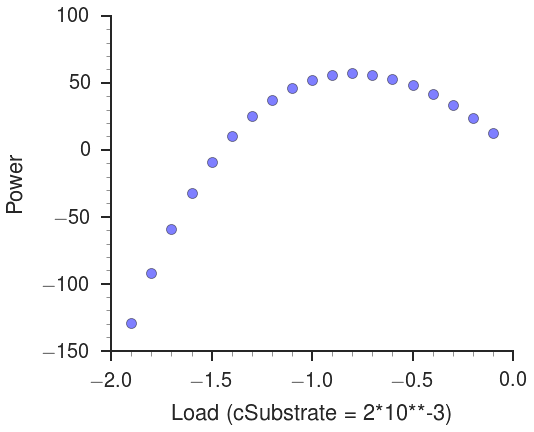

In [77]:
this = simulation(data_source='adk_md_data')
this.name = 'chi3TYR133'
this.cSubstrate = 2*10**-3
this.load = True
powers = []
fluxes = []
loads = []
for load_slope in np.arange(-0.1, -2, -0.1):
    this.load_slope = load_slope
    this.simulate()
    fluxes.append(np.mean(this.flux_u + this.flux_b))
    powers.append(load_slope * np.mean(this.flux_u + this.flux_b))
    loads.append(load_slope)
ax = aesthetics.generic_plot(fluxes, powers, 'Flux (cSubstrate = 2*10**-3)', 'Power', scientific=True)
#ax.set_xlim([-1, 2.1])
ax = aesthetics.generic_plot(loads, powers, 'Load (cSubstrate = 2*10**-3)', 'Power', scientific=True)
ax.set_xlim([-2.0, 0])

/mnt/639f049e-1c5c-4215-bb93-e396da93aa2b/projects/nonequilibrium/code/SG-model-v2/simulation.py:297: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


(-13.0, 2)

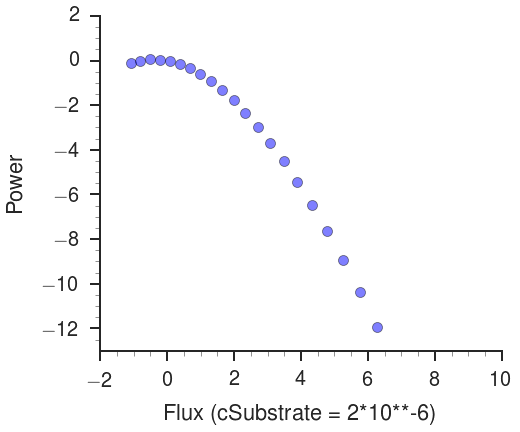

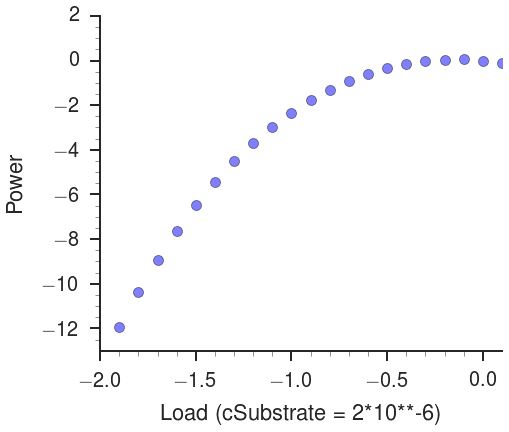

In [86]:
this = simulation(data_source='adk_md_data')
this.name = 'chi3TYR133'
this.cSubstrate = 2*10**-6
this.load = True
powers = []
fluxes = []
loads = []
for load_slope in np.arange(0.1, -2, -0.1):
    this.load_slope = load_slope
    this.simulate()
    fluxes.append(np.mean(this.flux_u + this.flux_b))
    powers.append(load_slope * np.mean(this.flux_u + this.flux_b))
    loads.append(load_slope)
ax = aesthetics.generic_plot(fluxes, powers, 'Flux (cSubstrate = 2*10**-6)', 'Power', scientific=True)
ax.set_xlim([-2, 10])
ax.set_ylim([-13.0, 2])
ax = aesthetics.generic_plot(loads, powers, 'Load (cSubstrate = 2*10**-6)', 'Power', scientific=True)
ax.set_xlim([-2.0, 0.1])
ax.set_ylim([-13.0, 2])

0
C                         +0.00e+00  second**-1
D                         +3.00e+12  degrees**2 second**-1
k_{cat}                   +3.12e+02  second**-1
[S]                       +2.00e-06  M         
dt                        +1.00e-13  second**-1
-----------------         ---------  --------- 
Intrasurface flux         +2.16e+00  cycle second**-1
Intersurface flux         +0.00e+00  cycle second**-1
-----------------         ---------  --------- 
Applied load              -1.90e+00  kcal mol**-1 cycle**-1
Power                     -4.10e+00  kcal mol**-1 second**-1


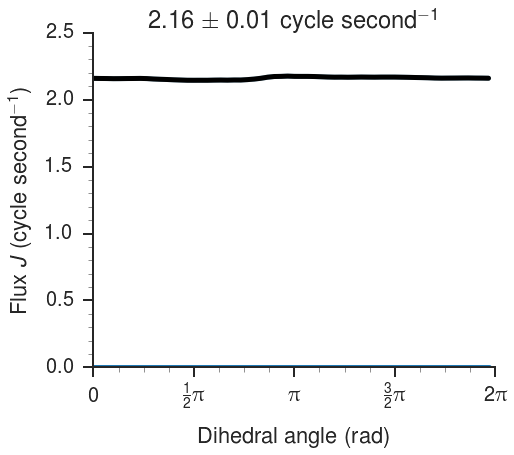

In [103]:

powers = []
fluxes = []
loads = []
for load_slope in np.arange(1, -2, -0.1):
    this = simulation(data_source='adk_md_data')
    this.name = 'chi1PRO27'
    this.cSubstrate = 2*10**-6
    this.C_intersurface = 0
    this.load = True
    this.load_slope = load_slope
    this.simulate()
    fluxes.append(np.mean(this.flux_u + this.flux_b))
    powers.append(load_slope * np.mean(this.flux_u + this.flux_b))
    loads.append(load_slope)
# ax = aesthetics.generic_plot(fluxes, powers, 'Flux (cSubstrate = 2*10**-6)', 'Power', scientific=True)
# ax.set_xlim([-1, 3])
# ax.set_ylim([-13.0, 2])
# ax = aesthetics.generic_plot(loads, powers, 'Load (cSubstrate = 2*10**-6)', 'Power', scientific=True)
# ax.set_xlim([-2.0, 1])
# ax.set_ylim([-13.0, 2])
print(this.C_intersurface)
this.plot_flux()

# Now what if I try to find the maximum load, through optimization, on the large and small substrate concentrations

In [45]:
flux, flux_std = get_flux('chi3TYR133')
max_power, max_load = get_power('chi3TYR133', flux)
print(max_power, max_load)

-0.000348575123842 -0.000347845991545


Intrasurface flux         +1.30e-02  cycle second**-1
Applied load              -1.00e-02  kcal mol**-1 cycle**-1
Power                     -1.30e-04  kcal mol**-1 second**-1
Intrasurface flux         +1.33e-02  cycle second**-1
Applied load              -9.00e-03  kcal mol**-1 cycle**-1
Power                     -1.19e-04  kcal mol**-1 second**-1
Intrasurface flux         +5.56e-03  cycle second**-1
Applied load              -8.00e-03  kcal mol**-1 cycle**-1
Power                     -4.45e-05  kcal mol**-1 second**-1
Intrasurface flux         +1.56e-02  cycle second**-1
Applied load              -7.00e-03  kcal mol**-1 cycle**-1
Power                     -1.09e-04  kcal mol**-1 second**-1
Intrasurface flux         +6.12e-03  cycle second**-1
Applied load              -6.00e-03  kcal mol**-1 cycle**-1
Power                     -3.67e-05  kcal mol**-1 second**-1
Intrasurface flux         +6.17e-03  cycle second**-1
Applied load              -5.00e-03  kcal mol**-1 cycle**-1
Power      

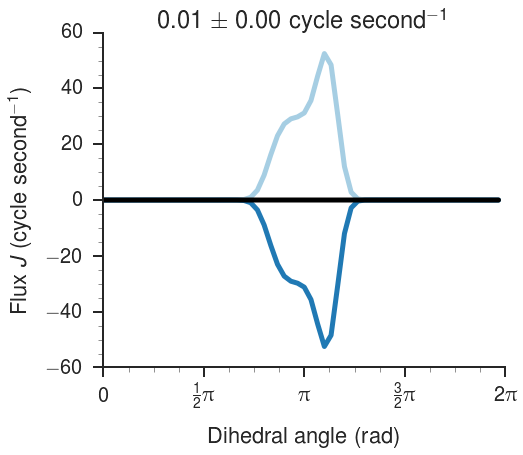

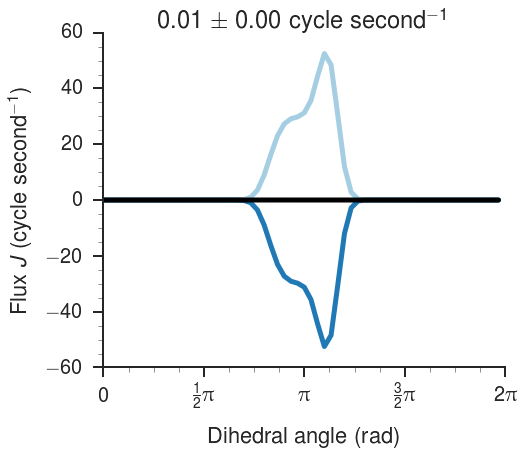

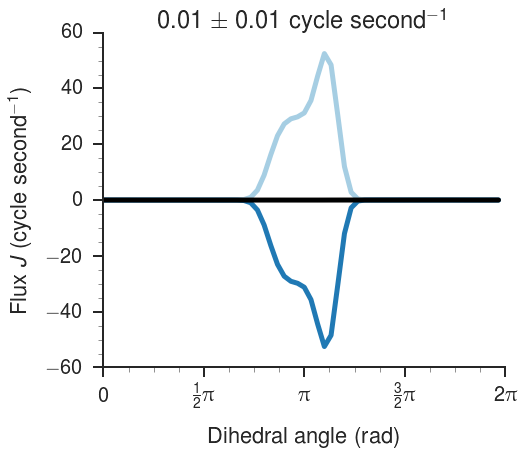

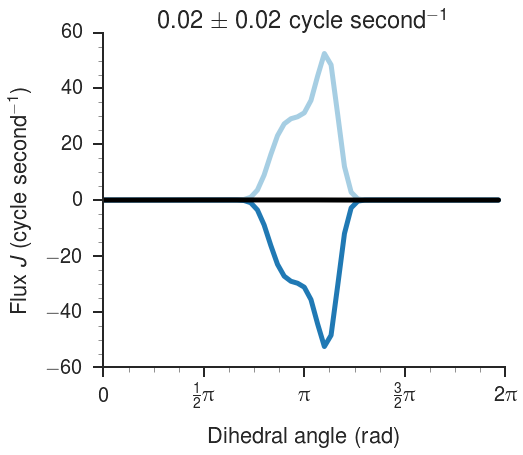

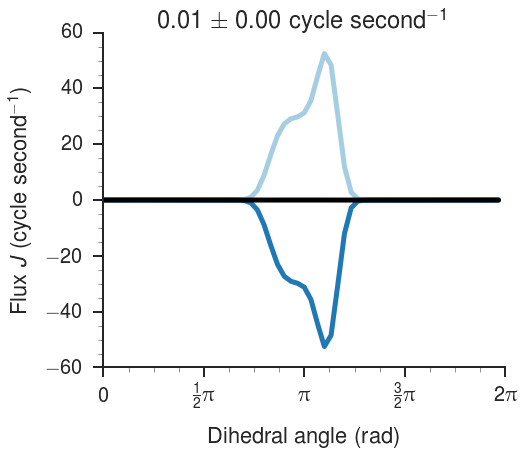

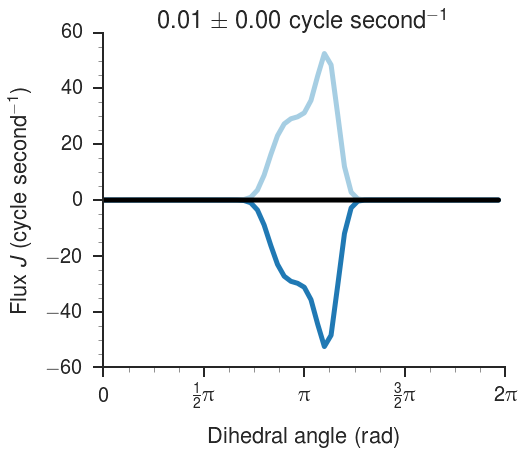

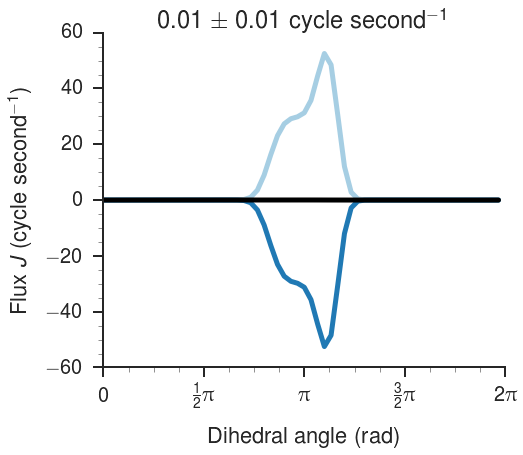

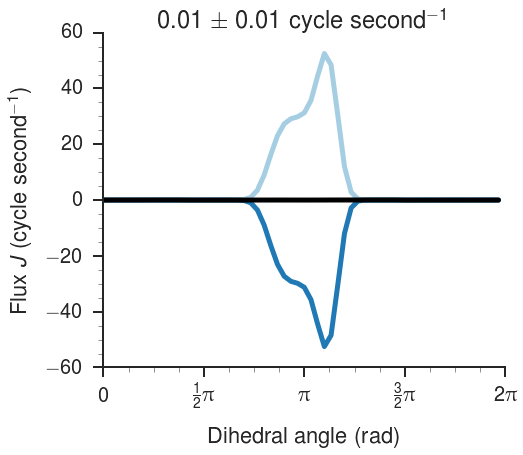

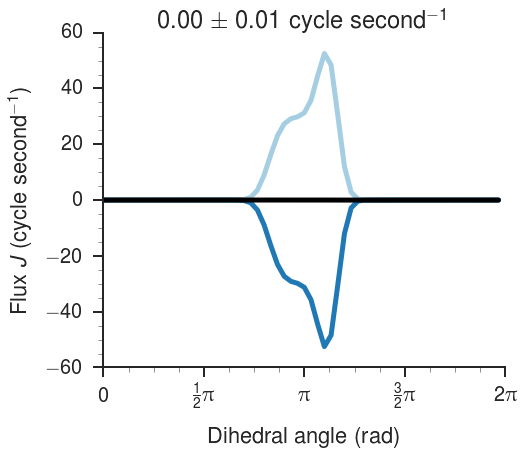

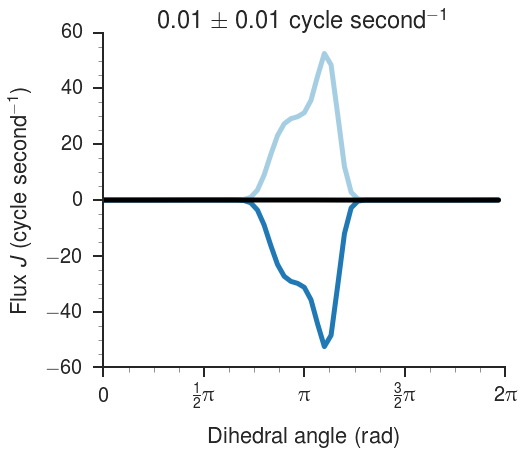

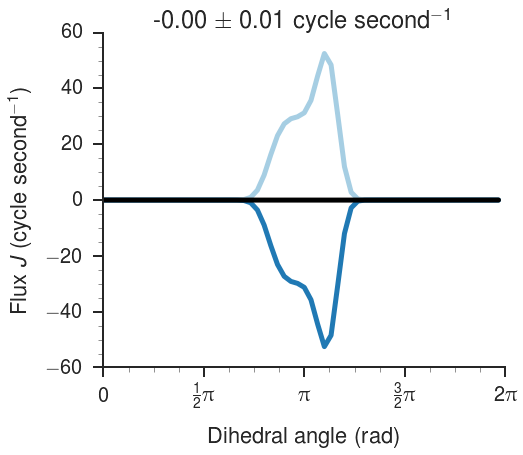

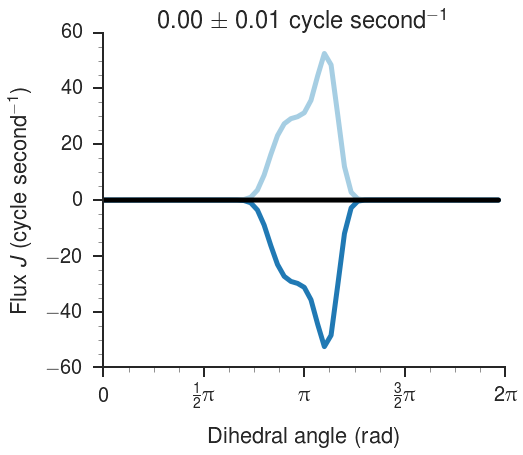

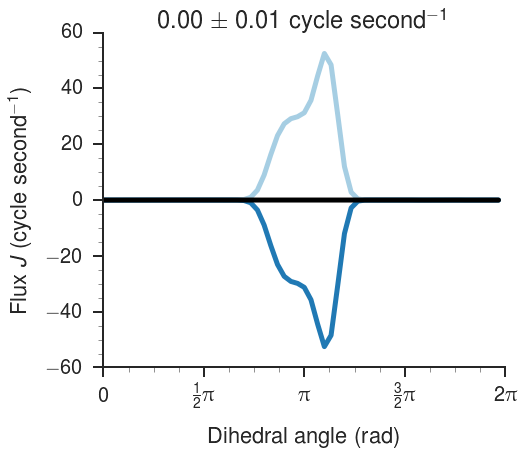

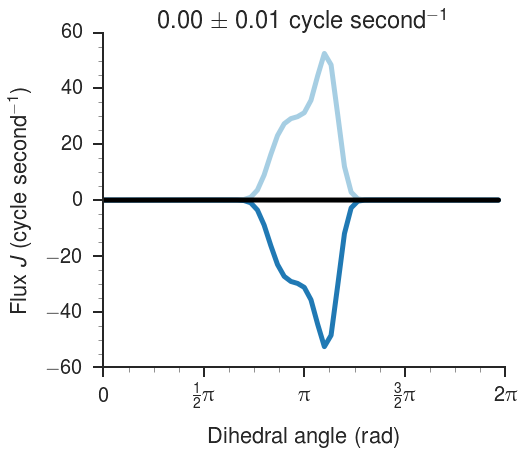

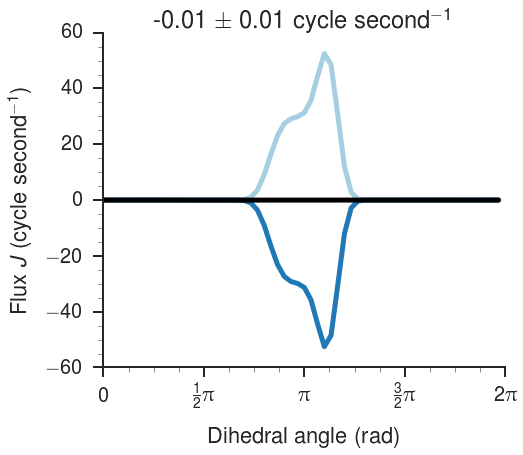

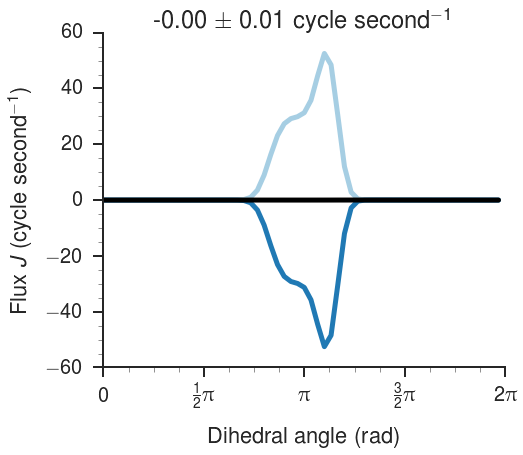

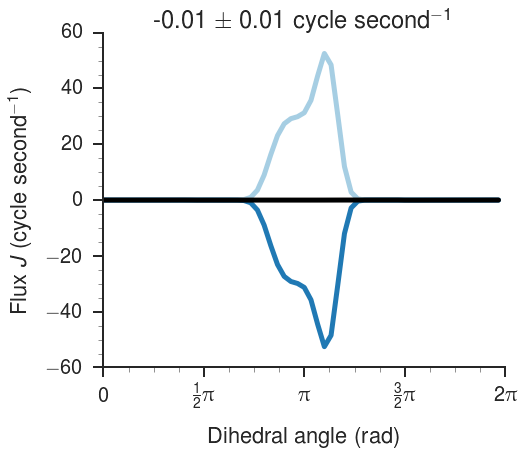

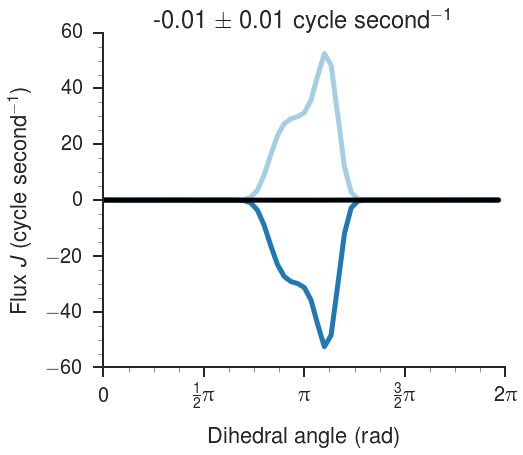

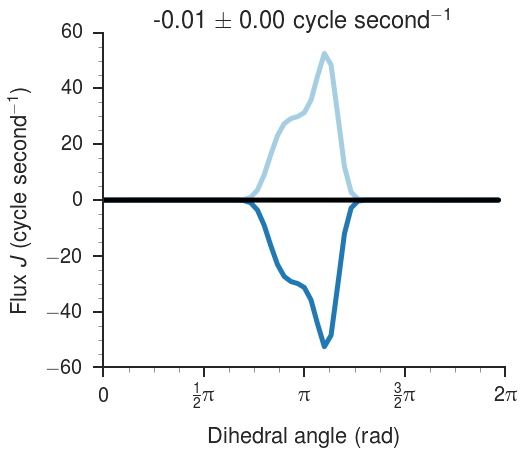

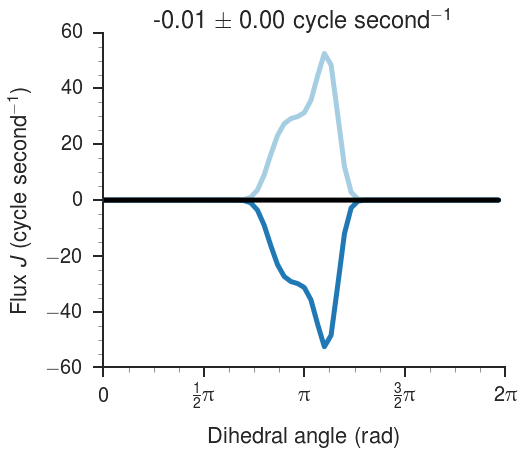

In [22]:
this = simulation(data_source='adk_md_data')
this.name = 'chi1PRO27'
this.load = True
fluxes = []
powers = []

this.cSubstrate = 0.2

for load_slope in np.arange(-0.01, 0.01, 0.001):
    this.load_slope = load_slope
    this.simulate(plot=False)
    this.plot_flux()
    print('{:<25} {:<+10.2e} {:<10}'.format('Intrasurface flux', np.mean(this.flux_u + this.flux_b),
                                           'cycle second**-1'))
    print('{:<25} {:<+10.2e} {:<10}'.format('Applied load', this.load_slope, 'kcal mol**-1 cycle**-1'))
    print('{:<25} {:<+10.2e} {:<10}'.format('Power', this.load_slope * np.mean(this.flux_u + this.flux_b),
                                           'kcal mol**-1 second**-1'))

    fluxes.append(np.mean(this.flux_u + this.flux_b))
    powers.append(load_slope * np.mean(this.flux_u + this.flux_b))
#aesthetics.generic_plot(fluxes, powers,
#                           'Flux', 'Power', scientific=True)

In [ ]:
for name in files_by_power['File'].values:
    putative_max_load = df[df['File'] == name]['Max load'].values
    putative_max_power = df[df['File'] == name]['Max power'].values
    print(name)
    flux = get_flux(name)
    print('Unbiased flux = {}'.format(flux))
    print('Putative maximum load = {}, generating power = {}'.format(putative_max_load, putative_max_power))
    ten_percent_less = putative_max_load - 0.1 * putative_max_load
    ten_percent_more = putative_max_load + 0.1 * putative_max_load
    loads = np.linspace(ten_percent_less, ten_percent_more, 20)
    for load in loads:
        print(load, power_from_load(load, name))        

Putative maximum load = [  1.50404262e-06], generating power = [ 0.00104103]
Load enabled!
Load enabled!
-2.44702832264e-09
Load enabled!
Load enabled!
5.94662256169e-09
Load enabled!
Load enabled!
-2.79568672117e-09
Load enabled!
Load enabled!
1.02379386248e-09
Load enabled!
Load enabled!
-2.70137061121e-09
Load enabled!
Load enabled!
-1.28868532828e-09
Load enabled!
Load enabled!
-2.89591564093e-09
Load enabled!
Load enabled!
-1.27243685846e-10
Load enabled!
Load enabled!
9.84350939257e-11
Load enabled!
Load enabled!
3.2321395272e-10
Load enabled!
Load enabled!
-5.59951375578e-10
Load enabled!
Load enabled!
-1.23539014339e-10
Load enabled!
Load enabled!
1.82655392047e-09
Load enabled!
Load enabled!
-6.06987218933e-10
Load enabled!
Load enabled!
-6.75764207935e-09
Load enabled!
Load enabled!
7.12175526116e-09
Load enabled!
Load enabled!
-5.47806080771e-09
Load enabled!
Load enabled!
-1.60249479686e-09
Load enabled!
Load enabled!
-3.70617723065e-09
Load enabled!
Load enabled!
-8.388908

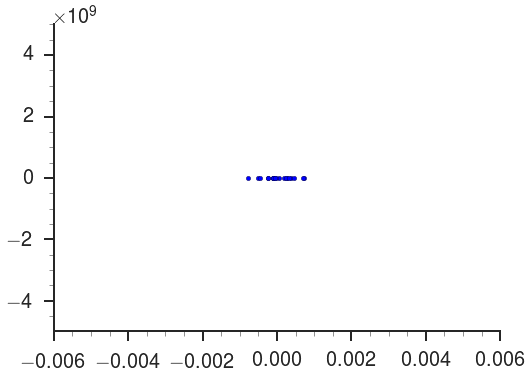

In [79]:
name = 'psiCYS77'
flux, flux_std = get_flux(name)
putative_max_load = df[df['File'] == name]['Max load'].values
putative_max_power = df[df['File'] == name]['Max power'].values
print('Putative maximum load = {}, generating power = {}'.format(putative_max_load, putative_max_power))
ten_percent_less = putative_max_load - 10 * putative_max_load
ten_percent_more = putative_max_load + 10 * putative_max_load
loads = np.linspace(ten_percent_less, ten_percent_more, 20)
fig = plt.figure()
for load in loads:
    # print(load, power_from_load(load, name))
    this = simulation(data_source = 'adk_md_data')
    this.load = True
    this.load_slope = load
    this.name = name
    this.simulate(plot=False)
    # plt.scatter(load, power_from_load(load, name))
    print(load*np.mean(this.flux_u + this.flux_b))
    
    plt.scatter(np.mean(this.flux_u + this.flux_b), load*np.mean(this.flux_u+this.flux_b))
plt.ylim([-5e9, 5e9])
aesthetics.paper_plot(fig)

## Write flux to files
This is to render the files in Chimera.

In [4]:
filename = 'adk-residues-by-flux'
attribute = 'flux'

file = str(filename) + '.dat'
f = open(file, 'w')
f.write('attribute: {}\n'.format(attribute))
f.write('match mode: any\n')
f.write('recipient: residues\n')
    # Loop over the residues
for i in range(1, max(df['ResID'].astype(int))):
    # For each residue, write the flux value that's the greatest...
    x = df[df['ResID'] == str(i)]['Flux with catalysis']
    value = max(abs(df[df['ResID'] == str(i)]['Flux with catalysis']))
    f.write('\t:{}\t{}\n'.format(i, value))
f.close()

/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


## Maximum power and efficiency

In [23]:
power_data = pd.DataFrame()
adk_dir = '../../md-data/adenylate-kinase/'
adk_unbound_files = sorted(glob.glob(adk_dir + 'AdKDihedHist_apo-4ake/' + '*'))
delta_g = -13 # kcal mol**-1 from ATP using cellular ATP, ADP, and P_i concentrations

def return_negative_power(value, *args):
        this = simulation(data_source='adk_md_data')
        this.load = True
        this.load_slope = value[0]
        this.name = args[0]
        this.simulate()
        power = (this.load_slope)*(np.mean(this.flux_u + this.flux_b))  
        power = -1.0 * power
        # print('Load\t{0:0.5f}\tFlux\t{1:0.2f}\tPower\t{2:0.2f}'.format(this.load_slope, np.mean(this.flux_u + this.flux_b),
        #                                                            power))

        return power

for file in range(len(adk_unbound_files)):
    name = os.path.splitext(os.path.basename(adk_unbound_files[file]))[0]
    name = re.search('^[^_]*', name).group(0)
    this = simulation(data_source='adk_md_data')
    this.name = name
    this.simulate()
    flux_with_catalysis = np.mean(this.flux_u + this.flux_b)
    print(name, flux_with_catalysis)
    if flux_with_catalysis > 0:
        positive = True
        # guess = 0.0001
        guess = np.random.uniform(low = 0.000001, high = 0.001)
    else:
        positive = False
        # guess = -0.0001
        guess = np.random.uniform(low = -0.000001, high = -0.001)
        
    result = sc.optimize.fmin(return_negative_power, (guess), args= (name, positive), full_output=True)
    efficiency = result[1] / (delta_g * np.sum(this.catalytic_rate * this.bound_population))
    if result[1] > 0:
        efficiency *= -1
        max_power = result[1]
    elif result[1] < 0:
        max_power = result[1] * -1
        
    power_data = power_data.append(pd.DataFrame({'Flux': flux_with_catalysis,
                'File': name,
                'ResID': re.match('.*?([0-9]+)$', name).group(1),
                'Max power': max_power,
                'Load at max power': result[0][0],
                'Efficiency' : efficiency
                }, index=[0]), ignore_index=True)
power_data.to_pickle('adk-flux-load-power.pickle')

chi1ALA11 -0.167630734108
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 22
chi1ALA127 -0.00878198354815
Optimization terminated successfully.
         Current function value: 0.000885
         Iterations: 6
         Function evaluations: 12
chi1ALA17 -0.0382956341685
Optimization terminated successfully.
         Current function value: 0.001288
         Iterations: 6
         Function evaluations: 12
chi1ALA176 0.0164050723581
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 22
chi1ALA186 0.0162246500608
Optimization terminated successfully.
         Current function value: 0.001583
         Iterations: 6
         Function evaluations: 12
chi1ALA188 0.0182184162162
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 22
chi1ALA194 0

/mnt/639f049e-1c5c-4215-bb93-e396da93aa2b/projects/nonequilibrium/code/SG-model-v2/simulation.py:301: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


Optimization terminated successfully.
         Current function value: -57.001313
         Iterations: 28
         Function evaluations: 57
chi3TYR171 31.8725875986
Optimization terminated successfully.
         Current function value: -0.000424
         Iterations: 1
         Function evaluations: 2
chi3TYR181 -22.6804983822
Optimization terminated successfully.
         Current function value: -0.000156
         Iterations: 10
         Function evaluations: 20
chi3TYR182 1.09482035099
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 9
         Function evaluations: 18
chi3TYR193 1.60382682585
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 11
         Function evaluations: 22
chi3TYR24 -43.1535360738
Optimization terminated successfully.
         Current function value: -0.000428
         Iterations: 10
         Function evaluations: 20
chi4ARG119 -0.03836630186
Optimization ter

In [26]:
power_data.sort_values(by='Max power', ascending=False).head()

,Efficiency,File,Flux,Load at max power,Max power,ResID
423,0.014054,chi3TYR133,-131.782468,-0.795935,57.001313,133
1099,0.003867,psiSER41,29.297670,1.047598,15.686548,41
806,0.000062,phiGLY42,-4.694402,-0.106682,0.250098,42
341,0.000053,chi2TYR181,-81.445411,-0.005254,0.214275,181
379,0.000012,chi3GLU187,-0.002600,-0.000038,0.048156,187


In [27]:
power_data.sort_values(by='Load at max power', ascending=False).head()

,Efficiency,File,Flux,Load at max power,Max power,ResID
1099,3.867492e-03,psiSER41,29.297670,1.047598,1.568655e+01,41
794,9.027661e-06,phiGLY12,23.321293,0.003125,3.661619e-02,12
797,2.390510e-10,phiGLY14,0.002081,0.001048,9.695909e-07,14
789,1.133734e-09,phiGLU70,0.004075,0.001046,4.598424e-06,70
941,1.972884e-10,psiALA93,0.000001,0.001034,8.002018e-07,93


In [28]:
power_data.sort_values(by='Efficiency', ascending=False).head()

,Efficiency,File,Flux,Load at max power,Max power,ResID
423,0.014054,chi3TYR133,-131.782468,-0.795935,57.001313,133
1099,0.003867,psiSER41,29.297670,1.047598,15.686548,41
806,0.000062,phiGLY42,-4.694402,-0.106682,0.250098,42
341,0.000053,chi2TYR181,-81.445411,-0.005254,0.214275,181
379,0.000012,chi3GLU187,-0.002600,-0.000038,0.048156,187


### Spot check some file to see that the load is actually at (or near) the power maximum

In [53]:
power_data.sort_values(by='Efficiency', ascending=False)[500:501]

,Efficiency,File,Flux,Load at max power,Max power,ResID
949,2.172201e-10,psiARG165,-0.000079,-0.000827,8.810446e-07,165


-7.94384953097e-05


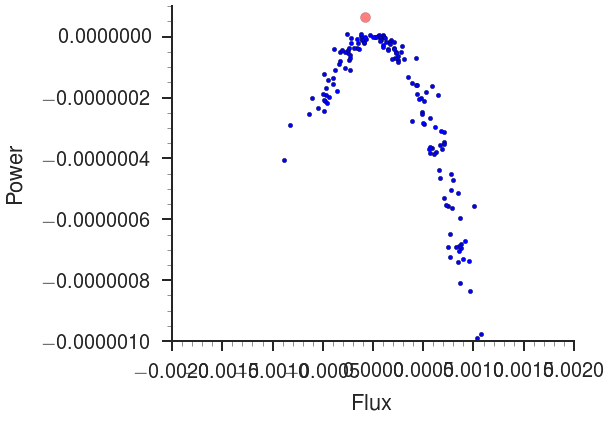

In [92]:
fig = plt.figure(figsize=(6 * 1.2, 6))
gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
ax = plt.subplot(gs[0, 0])
this = simulation(data_source='adk_md_data')
this.name = 'psiARG165'
for load in np.arange(0.000500, -0.00100, -0.00001):
    this.load = True
    this.load_slope = load
    this.simulate()
    ax.scatter(
        np.mean(this.flux_u + this.flux_b), this.load_slope *
        np.mean(this.flux_u + this.flux_b))
this = simulation(data_source='adk_md_data')
this.name = 'psiARG165'
this.load_slope = -0.000827
this.simulate()
ax.scatter(
    np.mean(this.flux_u + this.flux_b),
    this.load_slope * np.mean(this.flux_u + this.flux_b),
    c='r',
    s=100,
    alpha=0.5)
print(np.mean(this.flux_u + this.flux_b))
ax.set_ylabel('Power')
ax.set_xlabel('Flux')
ax.set_ylim([-0.000001, 0.0000001])
ax.set_xlim([-0.002, 0.002])
aesthetics.paper_plot(fig)

C_intrasurface = 	8.33e+10 second**-1
D = 			3.00e+12 degrees**2 second**-1
C_intersurface = 	1.00e+06 mol**-1 second**-1
Catalytic rate = 	312 second**-1
ATP concentration = 	0.002 M
Time step = 		1.00e-12 second
Intrasurface flux = 	-0.00 +/- 0.00 cycles second**-1
Intersurface flux = 	-0.00 +/- 0.00 cycles second**-1


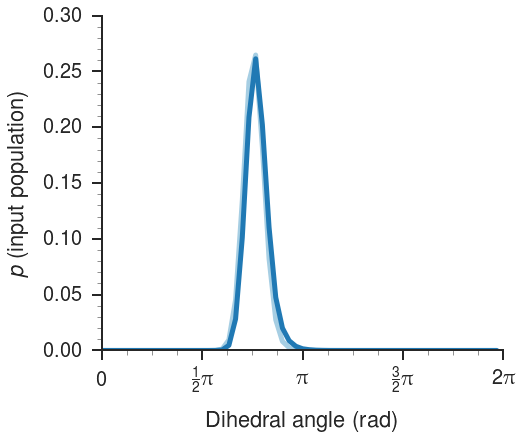

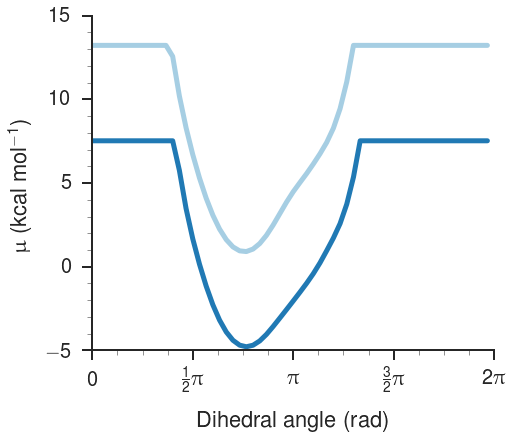

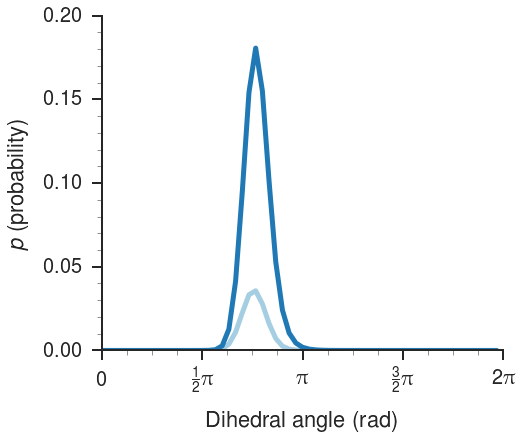

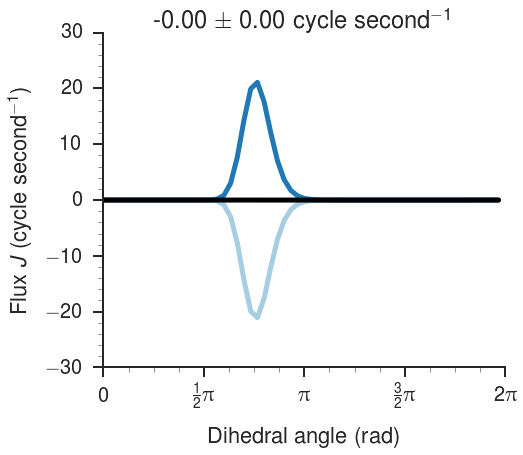

In [108]:
this = simulation(data_source = 'adk_md_data')
this.name = 'psiARG165'
this.simulate(plot=True)

In [104]:
this.C_intersurface

1000000

In [106]:
((10**6)*(400)) / ((200)*(np.exp(12/0.6)))

0.0041223072448771155

## Number of "interesting" torsions

In [5]:
total_angles = len(df)
some_flux = len(df[abs(df['Flux with catalysis']) > 1])
print('{} / {}'.format(some_flux, total_angles))

135 / 1138


# chi2THR175
This file is pretty interesting, eh?
## Flux

/mnt/639f049e-1c5c-4215-bb93-e396da93aa2b/projects/nonequilibrium/code/SG-model-v2/simulation.py:229: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  [extended_u[i] + self.load_function(i) for i in np.arange(-1*self.bins/2, self.bins + self.bins/2)],
/mnt/639f049e-1c5c-4215-bb93-e396da93aa2b/projects/nonequilibrium/code/SG-model-v2/simulation.py:233: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  [extended_b[i] + self.load_function(i) for i in np.arange(-1*self.bins/2, self.bins + self.bins/2)],


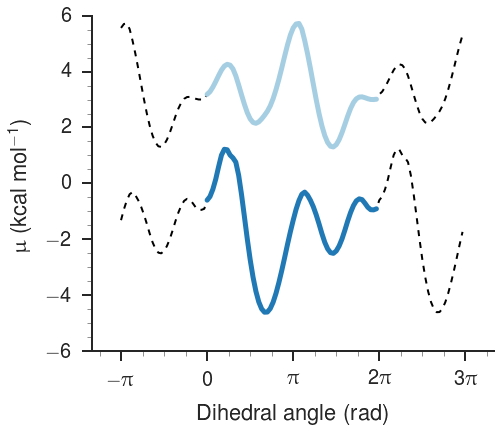

C_intrasurface = 	8.33e+10 second**-1
D = 			3.00e+12 degrees**2 second**-1
C_intersurface = 	1.00e+06 mol**-1 second**-1
Catalytic rate = 	312 second**-1
ATP concentration = 	0.002 M
Time step = 		1.00e-12 second


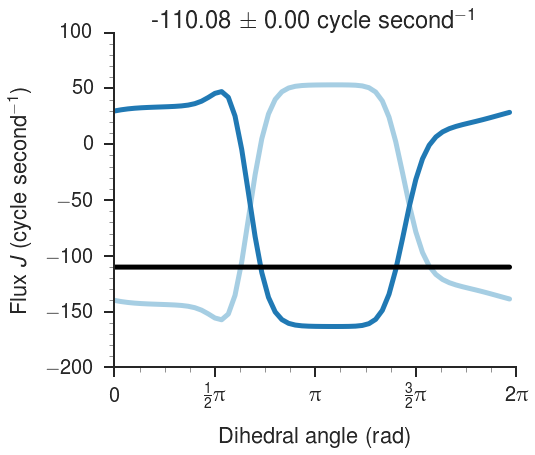

In [77]:
this = simulation(data_source='adk_md_data')
this.name = 'chi2THR175'
this.load = True
this.load_slope = -0.0001
this.simulate()
# this.plot_load()
this.plot_load_extrapolation()
this.plot_flux()

## Load

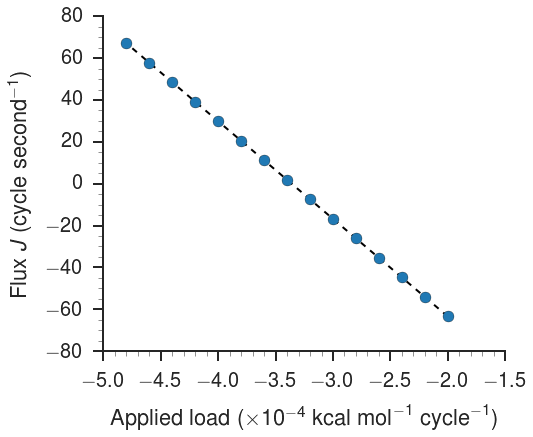

In [140]:
fig = plt.figure(figsize=(6*1.2,6), dpi=300)
ax = fig.add_subplot(111)
cmap = sns.color_palette("Paired", 10)
loads = []
fluxes = []
for load in np.arange(-2e-4, -5e-4, -2e-5):
    this = simulation(data_source='adk_md_data')
    this.name = 'chi2THR175'
    this.load = True
    this.load_slope = load
    this.simulate()
    ax.scatter(this.load_slope/1e-4, np.mean(this.flux_u + this.flux_b), c=cmap[1], s=120)
    loads.append(this.load_slope)
    fluxes.append(np.mean(this.flux_u + this.flux_b))
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(loads,fluxes)


ax.plot(np.arange(-2e-4, -5e-4, -2e-5)/1e-4, slope*np.arange(-2e-4, -5e-4, -2e-5) + intercept, c='k', ls='--', lw=2, zorder=-1,
       label='{0:2.2f}'.format(slope))
aesthetics.paper_plot(fig)
ax.set_xlabel(r'Applied load ($\times 10^{-4} \text{ kcal mol}^{-1} \text{ cycle}^{-1}$)')
ax.set_ylabel(r'Flux $J$ (cycle second$^{-1}$)')

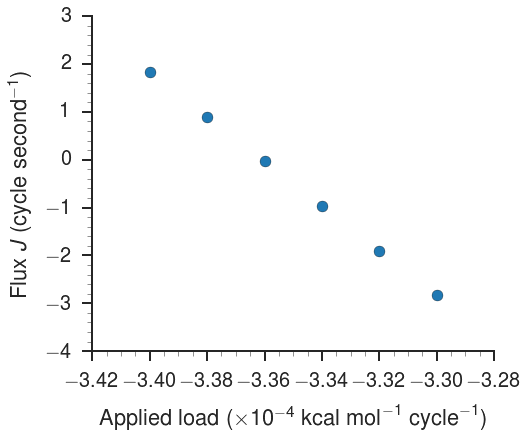

In [182]:
fig = plt.figure(figsize=(6*1.2,6), dpi=300)
ax = fig.add_subplot(111)
cmap = sns.color_palette("Paired", 10)
loads = []
fluxes = []
for load in np.arange(-3.3e-4, -3.4e-4, -2e-6):
    this = simulation(data_source='adk_md_data')
    this.name = 'chi2THR175'
    this.load = True
    this.load_slope = load
    this.simulate()
    ax.scatter(this.load_slope/1e-4, np.mean(this.flux_u + this.flux_b), c=cmap[1], s=120)
    loads.append(this.load_slope)
    fluxes.append(np.mean(this.flux_u + this.flux_b))
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(loads,fluxes)


# ax.plot(np.arange(-3.3e-4, -3.4e-4, -2e-5)/1e-4, slope*np.arange(-3.3e-4, -3.4e-4, -2e-5) + intercept, c='k', ls='--', lw=2, zorder=-1,
#        label='{0:2.2f}'.format(slope))
aesthetics.paper_plot(fig)
ax.set_xlabel(r'Applied load ($\times 10^{-4} \text{ kcal mol}^{-1} \text{ cycle}^{-1}$)')
ax.set_ylabel(r'Flux $J$ (cycle second$^{-1}$)')

## Power

0.0131646388962


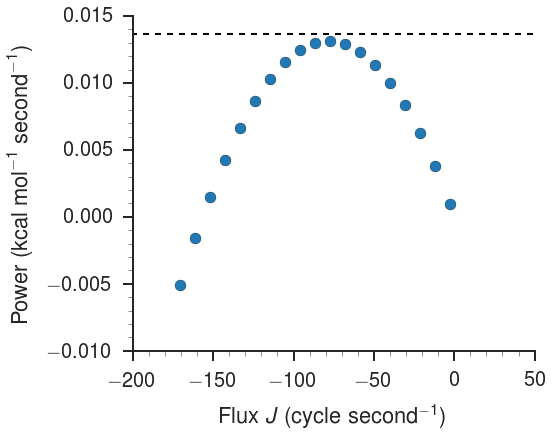

In [50]:
fig = plt.figure(figsize=(6*1.2,6), dpi=300)
ax = fig.add_subplot(111)
cmap = sns.color_palette("Paired", 10)
powers = []
for load in np.arange(-3.3e-4, 0.4e-4, 2e-5):
    this = simulation(data_source='adk_md_data')
    this.name = 'chi2THR175'
    this.load = True
    this.load_slope = load
    this.simulate()
    ax.scatter(  np.mean(this.flux_u + this.flux_b), (this.load_slope)*(np.mean(this.flux_u + this.flux_b)), c=cmap[1], s=120)
    powers.append((this.load_slope)*(np.mean(this.flux_u + this.flux_b)))

ax.axhline(y=np.max(powers) + 0.0005, xmin=-200, xmax=200, c='k', ls='--', lw=2)
aesthetics.paper_plot(fig)
ax.set_ylabel(r'Power ($\text{kcal mol}^{-1} \text{ second}^{-1}$)')
ax.set_xlabel(r'Flux $J$ (cycle second$^{-1}$)')
print(np.max(powers))

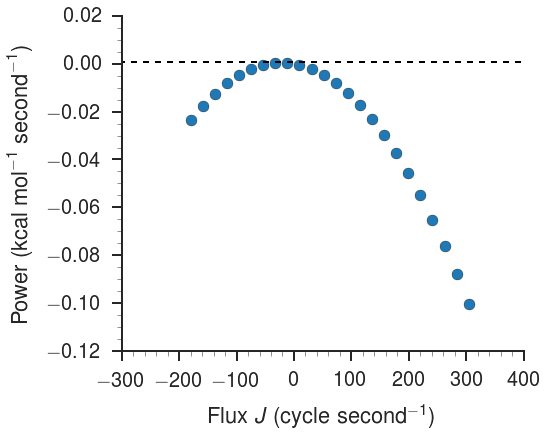

In [5]:
# chi3TYR24
fig = plt.figure(figsize=(6*1.2,6), dpi=300)
ax = fig.add_subplot(111)
cmap = sns.color_palette("Paired", 10)
powers = []
for load in np.arange(-3.3e-4, 1.4e-4, 2e-5):
    this = simulation(data_source='adk_md_data')
    this.name = 'chi3TYR24'
    this.load = True
    this.load_slope = load
    this.simulate()
    ax.scatter(np.mean(this.flux_u + this.flux_b), (this.load_slope)*(np.mean(this.flux_u + this.flux_b)), c=cmap[1], s=120)
    powers.append((this.load_slope)*(np.mean(this.flux_u + this.flux_b)))

ax.axhline(y=np.max(powers) + 0.0005, xmin=-200, xmax=200, c='k', ls='--', lw=2)
aesthetics.paper_plot(fig)
ax.set_ylabel(r'Power ($\text{kcal mol}^{-1} \text{ second}^{-1}$)')
ax.set_xlabel(r'Flux $J$ (cycle second$^{-1}$)')

## Maximum power

In [24]:
power_data = pd.DataFrame()
# delta_g = 12 # kcal/mol converted from 20 kT (ish...)
delta_g = -13


adk_dir = '../../md-data/adenylate-kinase/'
adk_unbound_files = sorted(glob.glob(adk_dir + 'AdKDihedHist_apo-4ake/' + '*'))
def return_negative_power(value, *args):
        this = simulation(data_source='adk_md_data')
        this.load = True
        this.load_slope = value[0]
        this.name = args[0]
        this.name = 'chi2THR175'
        this.simulate()
        power = (this.load_slope)*(np.mean(this.flux_u + this.flux_b))  
        if not args[1]:
            power = -1.0 * power
        print('Load\t{0:0.2f}\tFlux\t{1:0.2f}\tPower\t{2:0.2f}'.format(this.load_slope, np.mean(this.flux_u + this.flux_b),
                                                                       power))

        return power

for file in range(len(adk_unbound_files)):
    name = os.path.splitext(os.path.basename(adk_unbound_files[file]))[0]
    name = re.search('^[^_]*', name).group(0)
    this = simulation(data_source='adk_md_data')
    this.name = name
    this.simulate()
    flux_with_catalysis = np.mean(this.flux_u + this.flux_b)
    print(name, flux_with_catalysis)
    if flux_with_catalysis > 0:
        positive = True
        # guess = 0.0001
        # Since I get some NaNs doing this...
        guess = np.random.uniform(low = 0.000001, high = 0.001)
    else:
        positive = False
        # guess = -0.0001
        guess = np.random.uniform(low = -0.000001, high = -0.001)
        print('Flux = {0:11.9f} should be negative'.format(flux_with_catalysis))
        print('Trying loads of ... {0:11.9f}'.format(guess))
    
    result = sc.optimize.fmin(return_negative_power, (guess), args= (name, positive), full_output=True)
    efficiency = result[1] / (delta_g * np.sum(this.catalytic_rate * this.bound_population))
    if result[1] > 0:
        efficiency *= -1
    
    power_data = power_data.append(pd.DataFrame({'Flux with catalysis': flux_with_catalysis,
                'File': name,
                'Max Power': -1.0 * result[1],
                'Load at max power': result[0][0],
                'Efficiency': efficiency,
                }, index=[0]), ignore_index=True)


chi1ALA11 -0.167630734108
Flux = -0.167630734 should be negative
Trying loads of ... -0.000358412
Load	-0.00	Flux	10.42	Power	0.00
Load	-0.00	Flux	18.77	Power	0.01
Load	-0.00	Flux	2.06	Power	0.00
Load	-0.00	Flux	-6.30	Power	-0.00
Load	-0.00	Flux	-23.01	Power	-0.01
Load	-0.00	Flux	-39.72	Power	-0.01
Load	-0.00	Flux	-73.15	Power	-0.01
Load	-0.00	Flux	-106.57	Power	-0.01
Load	-0.00	Flux	-106.57	Power	-0.01
Load	-0.00	Flux	-89.86	Power	-0.01
Load	-0.00	Flux	-56.43	Power	-0.01
Load	-0.00	Flux	-81.50	Power	-0.01
Optimization terminated successfully.
         Current function value: -0.013145
         Iterations: 6
         Function evaluations: 12
chi1ALA127 -0.00878198354815
Flux = -0.008781984 should be negative
Trying loads of ... -0.000336212
Load	-0.00	Flux	0.06	Power	0.00
Load	-0.00	Flux	7.90	Power	0.00
Load	-0.00	Flux	-7.77	Power	-0.00
Load	-0.00	Flux	-15.61	Power	-0.00
Load	-0.00	Flux	-31.29	Power	-0.01
Load	-0.00	Flux	-46.97	Power	-0.01
Load	-0.00	Flux	-78.32	Power	-0.01
Load	-0.00	

/mnt/639f049e-1c5c-4215-bb93-e396da93aa2b/projects/nonequilibrium/code/SG-model-v2/simulation.py:301: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


Load	0.21	Flux	-91077.40	Power	-18833.14
Load	0.28	Flux	-119168.70	Power	-32852.71
Load	0.41	Flux	-172541.58	Power	-71343.11
Load	0.55	Flux	-222672.53	Power	-122755.99
Load	0.83	Flux	-315396.19	Power	-260797.11
Load	1.10	Flux	-401228.03	Power	-442349.81
Load	1.65	Flux	-564361.37	Power	-933281.43
Load	2.20	Flux	-731135.37	Power	-1612080.15
Load	3.31	Flux	-1124494.18	Power	-3719050.38
Load	4.41	Flux	-1656175.86	Power	-7303270.95
Load	6.61	Flux	-3404575.68	Power	-22519699.47
Load	8.82	Flux	-6662333.42	Power	-58757510.48
Load	13.23	Flux	-22421745.90	Power	-296617245.38
Load	17.64	Flux	-63682002.74	Power	-1123263804.73
Load	26.46	Flux	-303299968.67	Power	-8024685492.98
Load	35.28	Flux	-762916251.47	Power	-26913546480.86
Load	52.92	Flux	-1807229048.50	Power	-95630889071.04
Load	70.55	Flux	-2851671074.67	Power	-201197693591.90
Load	105.83	Flux	-5415310231.35	Power	-573110023284.18
Load	141.11	Flux	-9272661962.32	Power	-1308451848072.37
Load	211.66	Flux	-25286859872.65	Power	-5352287038242.99


OverflowError: cannot convert float infinity to integer

In [17]:
power_data.sort_values(by = 'Efficiency', ascending=True).head(5)

,Efficiency,File,Flux with catalysis,Load at max power,Max Power
1,0.000003,chi1ALA127,-0.008782,-0.000175,0.013144
0,0.000003,chi1ALA11,-0.167631,-0.000175,0.013144
2,0.000003,chi1ALA17,-0.038296,-0.000175,0.013144


In [12]:
power_data.sort_values(by = 'Efficiency', ascending=False).tail()

,Efficiency,File,Flux with catalysis,Load at max power,Max Power
161,0.000003,chi1THR163,-156.700962,-0.000175,0.013144
753,0.000003,phiASP147,-156.702244,-0.000175,0.013144
162,0.000003,chi1THR175,-156.700962,-0.000175,0.013144
751,0.000003,phiASP118,-156.702244,-0.000175,0.013144
0,0.000003,chi1ALA11,-156.700962,-0.000175,0.013144


In [13]:
power_data.sort_values('Max Power', ascending=False).head(n=10)

,Efficiency,File,Flux with catalysis,Load at max power,Max Power
569,0.000003,omegaGLU185,-156.700962,-0.000175,0.013144
386,0.000003,chi3GLU75,-156.702244,-0.000175,0.013144
606,0.000003,omegaILE212,-156.700962,-0.000175,0.013144
607,0.000003,omegaILE26,-156.700962,-0.000175,0.013144
608,0.000003,omegaILE29,-156.700962,-0.000175,0.013144
609,0.000003,omegaILE3,-156.700962,-0.000175,0.013144
610,0.000003,omegaILE4,-156.700962,-0.000175,0.013144
611,0.000003,omegaILE52,-156.700962,-0.000175,0.013144
612,0.000003,omegaILE65,-156.700962,-0.000175,0.013144
613,0.000003,omegaILE72,-156.700962,-0.000175,0.013144


In [14]:
total_power = np.sum(power_data['Max Power'])
total_power_ratio = total_power / (delta_g * this.catalytic_rate)
print('{0:11.9f} kcal mol**-1 second**-1 \t{1:11.9f}'.format(total_power, total_power_ratio))

14.957849214 kcal mol**-1 second**-1 	-0.003687833


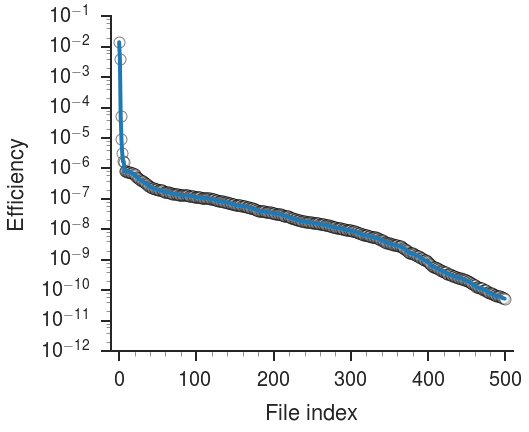

In [81]:
fig = plt.figure(figsize=(6*1.2,6), dpi=300)
ax = fig.add_subplot(111)
cmap = sns.color_palette("Paired", 10)

ax.scatter(range(500), power_data.sort_values(by = 'Efficiency', ascending=False)['Efficiency'].head(500), 
          s = 120, c ='w', edgecolor = 'k', lw=1, alpha=0.5)
ax.plot(range(500), power_data.sort_values(by = 'Efficiency', ascending=False)['Efficiency'].head(500), 
          lw=4, c = cmap[1])


aesthetics.paper_plot(fig, scientific=False)
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(10))
ax.set_ylim([10**-12, 10**-1])
ax.set_xlim([-10, 510])
ax.set_ylabel('Efficiency')
ax.set_xlabel('File index')
ax.set_yscale('log')


C_intrasurface = 	8.33e+10 second**-1
D = 			3.00e+12 degrees**2 second**-1
C_intersurface = 	1.00e+06 mol**-1 second**-1
Catalytic rate = 	312 second**-1
ATP concentration = 	0.002 M
Time step = 		1.00e-12 second
Intrasurface flux = 	-131.78 +/- 0.00 cycles second**-1


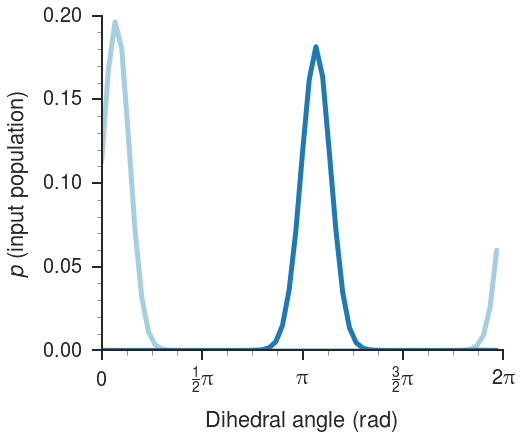

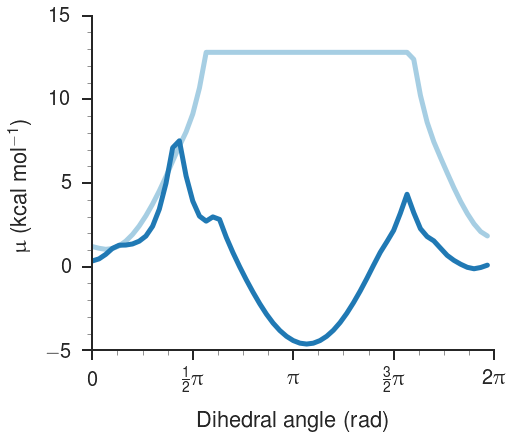

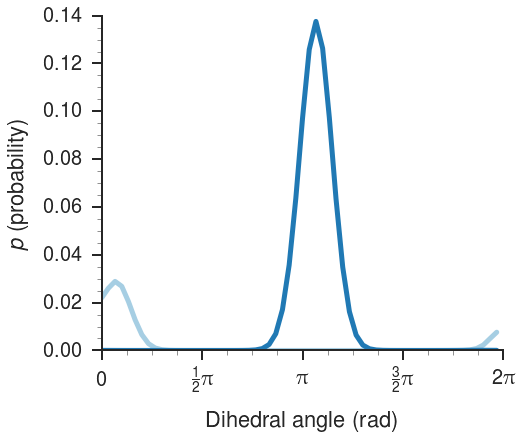

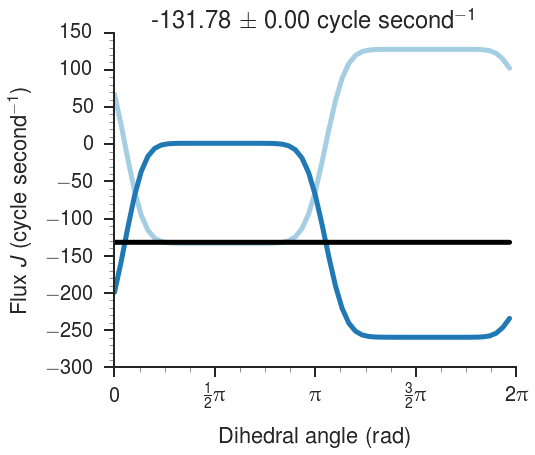

In [118]:
this = simulation(data_source='adk_md_data')
this.name = 'chi3TYR133'
this.simulate(plot=True)

In [120]:
np.sum(power_data['Max Power']) / (delta_g * this.catalytic_rate)

-0.01796695583224878

/Users/dslochower/Documents/Documents - Triceratops/projects/nonequilibrium/code/SG-model-v2/simulation.py:367: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


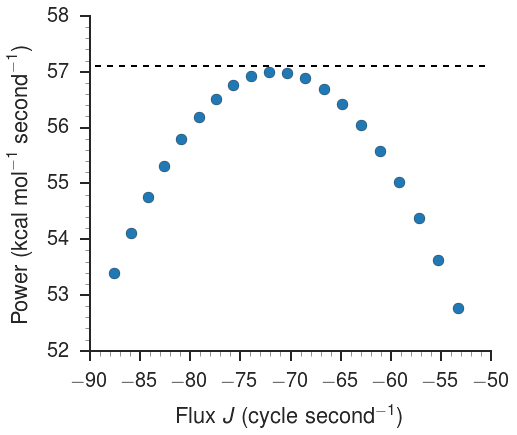

In [96]:
fig = plt.figure(figsize=(6*1.2,6), dpi=300)
ax = fig.add_subplot(111)
cmap = sns.color_palette("Paired", 10)
target = -0.79
for load in np.arange(target-0.2, target+0.2, 0.02):
    this = simulation(data_source='adk_md_data')
    this.name = 'chi3TYR133'
    this.load = True
    this.load_slope = load
    this.simulate()
    ax.scatter(np.mean(this.flux_u + this.flux_b), (this.load_slope)*(np.mean(this.flux_u + this.flux_b)), c=cmap[1], s=120)

this = simulation(data_source='adk_md_data')
this.name = 'chi3TYR133'
this.load = True
this.load_slope = target
this.simulate()
ax.axhline(y=(this.load_slope)*(np.mean(this.flux_u + this.flux_b))+0.1, xmin=-200, xmax=200, c='k', ls='--', lw=2, zorder=-1)

aesthetics.paper_plot(fig, scientific=False)
ax.set_ylabel(r'Power ($\text{kcal mol}^{-1} \text{ second}^{-1}$)')
ax.set_xlabel(r'Flux $J$ (cycle second$^{-1}$)')

In [16]:
power_data.sort_values(by = 'Max Power', ascending=False).head(5)

,Efficiency,File,Flux with catalysis,Load at max power,Max Power
423,0.015225,chi3TYR133,-131.783735,-0.799135,57.001244
1099,0.004190,psiSER41,29.298257,1.045455,15.685991
341,0.000057,chi2TYR181,-81.446152,-0.005295,0.214267
794,0.000010,phiGLY12,23.286953,0.003095,0.036723
332,0.000004,chi2THR175,-156.701403,-0.000175,0.013144


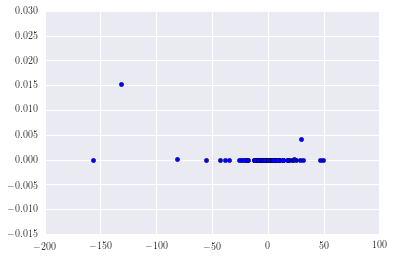

In [20]:
plt.scatter(power_data['Flux with catalysis'], power_data['Efficiency'])

C_intrasurface = 	8.33e+10 second**-1
D = 			3.00e+12 degrees**2 second**-1
C_intersurface = 	1.00e+06 mol**-1 second**-1
Catalytic rate = 	312 second**-1
ATP concentration = 	0.002 M
Time step = 		1.00e-12 second
Intrasurface flux = 	-43.15 +/- 0.00 cycles second**-1


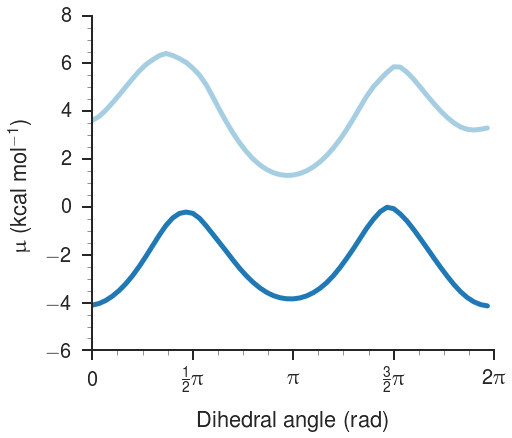

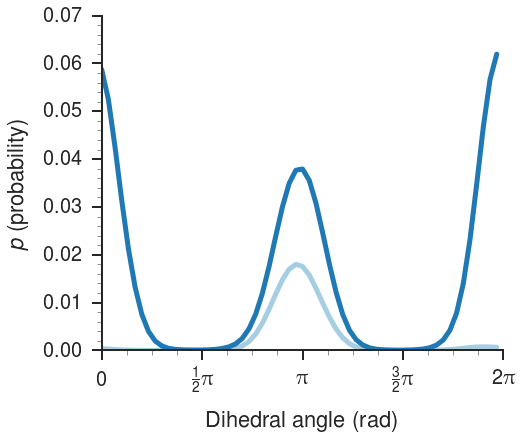

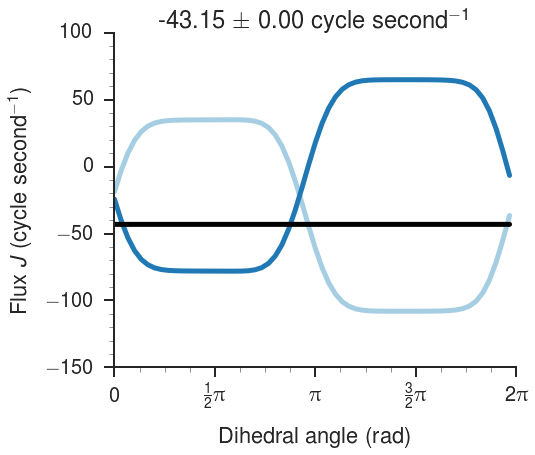

In [83]:
this = simulation(data_source='adk_md_data')
this.name = 'chi3TYR24'
this.simulate(plot=True)

Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offs

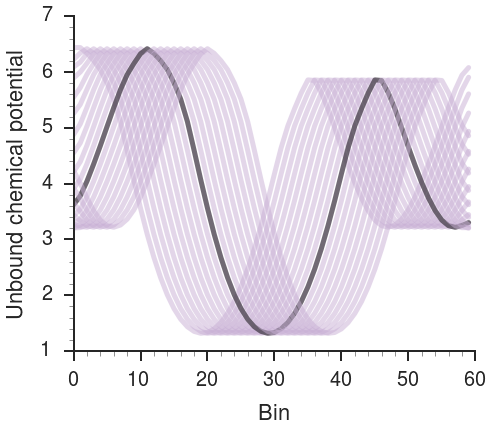

In [109]:
fig = plt.figure(figsize=(6*1.2,6), dpi=300)
ax = fig.add_subplot(111)
cmap = sns.color_palette("Paired", 10)

for phase_shift in range(-10, 10):
    this = simulation(data_source='manual')
    this.name = 'chi3TYR24'
    this.dir = '../../md-data/adenylate-kinase'
    this.unbound_population = np.genfromtxt(this.dir + '/AdKDihedHist_apo-4ake/' +
                                            this.name + '.dat',
                                            delimiter=' ',
                                            skip_header=1,
                                            usecols=1)
    this.unbound_population = np.roll(this.unbound_population, phase_shift)
    this.bound_population = np.genfromtxt(this.dir + '/AdKDihedHist_ap5-3hpq/' +
                                            this.name + '.dat',
                                            delimiter=' ',
                                            skip_header=1,
                                            usecols=1)

    this.C_intersurface = 10 ** 6  # per mole per second
    this.offset_factor = 5.7  # kcal per mol
    this.catalytic_rate = 312  # per second
    this.simulate()
    ax.plot(range(len(this.unbound)), this.unbound, c=this.unbound_clr, alpha=0.5)
    if phase_shift == 0:
            ax.plot(range(len(this.unbound)), this.unbound, c='k', alpha=0.5)
ax.set_ylabel('Unbound chemical potential')
ax.set_xlabel('Bin')
aesthetics.paper_plot(fig)

Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offs

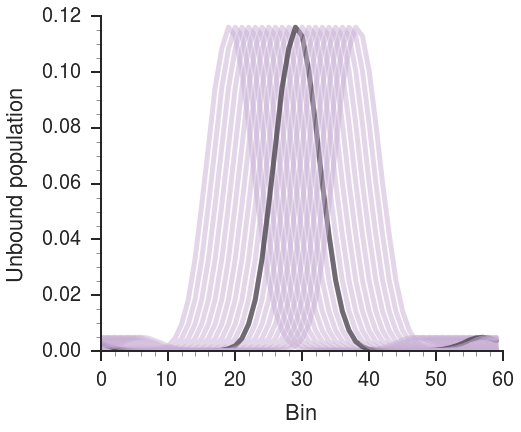

In [101]:
fig = plt.figure(figsize=(6*1.2,6), dpi=300)
ax = fig.add_subplot(111)
cmap = sns.color_palette("Paired", 10)

for phase_shift in range(-10, 10):
    this = simulation(data_source='manual')
    this.name = 'chi3TYR24'
    this.dir = '../../md-data/adenylate-kinase'
    this.unbound_population = np.genfromtxt(this.dir + '/AdKDihedHist_apo-4ake/' +
                                            this.name + '.dat',
                                            delimiter=' ',
                                            skip_header=1,
                                            usecols=1)
    this.unbound_population = np.roll(this.unbound_population, phase_shift)
    this.bound_population = np.genfromtxt(this.dir + '/AdKDihedHist_ap5-3hpq/' +
                                            this.name + '.dat',
                                            delimiter=' ',
                                            skip_header=1,
                                            usecols=1)

    this.C_intersurface = 10 ** 6  # per mole per second
    this.offset_factor = 5.7  # kcal per mol
    this.catalytic_rate = 312  # per second
    this.simulate()
    ax.plot(range(len(this.unbound_population)), this.unbound_population, c=this.unbound_clr, alpha=0.5)
    if phase_shift == 0:
            ax.plot(range(len(this.unbound_population)), this.unbound_population, c='k', alpha=0.5)
ax.set_ylabel('Unbound population')
ax.set_xlabel('Bin')
aesthetics.paper_plot(fig)

Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offset, and catalytic rate.
Using manual parameters, specify C, offs

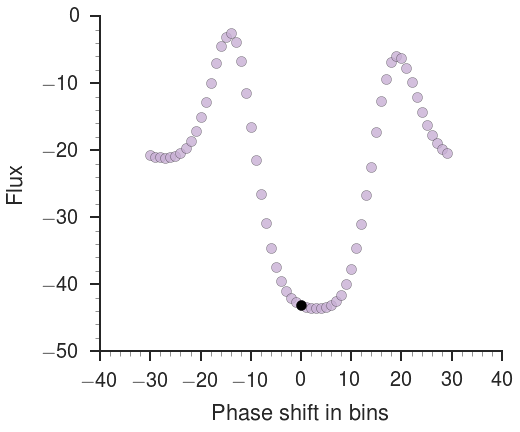

In [108]:
fig = plt.figure(figsize=(6*1.2,6), dpi=300)
ax = fig.add_subplot(111)
cmap = sns.color_palette("Paired", 10)

for phase_shift in range(-30, 30):
    this = simulation(data_source='manual')
    this.name = 'chi3TYR24'
    this.dir = '../../md-data/adenylate-kinase'
    this.unbound_population = np.genfromtxt(this.dir + '/AdKDihedHist_apo-4ake/' +
                                            this.name + '.dat',
                                            delimiter=' ',
                                            skip_header=1,
                                            usecols=1)
    this.unbound_population = np.roll(this.unbound_population, phase_shift)
    this.bound_population = np.genfromtxt(this.dir + '/AdKDihedHist_ap5-3hpq/' +
                                            this.name + '.dat',
                                            delimiter=' ',
                                            skip_header=1,
                                            usecols=1)

    this.C_intersurface = 10 ** 6  # per mole per second
    this.offset_factor = 5.7  # kcal per mol
    this.catalytic_rate = 312  # per second
    this.simulate()
    ax.scatter(phase_shift, np.mean(this.flux_u + this.flux_b), c=this.unbound_clr, alpha=0.8, s=100)
    if phase_shift == 0:
            ax.scatter(0, np.mean(this.flux_u + this.flux_b), c='k', alpha=1, s=100, zorder=2)
ax.set_ylabel('Flux')
ax.set_xlabel('Phase shift in bins')
aesthetics.paper_plot(fig)

In [86]:

fluxes = []
loads = []
powers = []

target = -0.79
for load in np.arange(target-0.2, target+0.2, 0.02):
    this = simulation(data_source='adk_md_data')
    this.name = 'chi3TYR133'
    this.load = True
    this.load_slope = load
    this.simulate()
    fluxes.append(np.mean(this.flux_u + this.flux_b))
    loads.append(this.load_slope)
    powers.append((this.load_slope)*(np.mean(this.flux_u + this.flux_b)))

/mnt/639f049e-1c5c-4215-bb93-e396da93aa2b/projects/nonequilibrium/code/SG-model-v2/simulation.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


C_intrasurface = 	8.33e+10 second**-1
D = 			3.00e+12 degrees**2 second**-1
C_intersurface = 	1.00e+06 mol**-1 second**-1
Catalytic rate = 	0 second**-1
ATP concentration = 	0.002 M
Time step = 		1.00e-12 second
Intrasurface flux = 	0.00 +/- 0.00 cycles second**-1


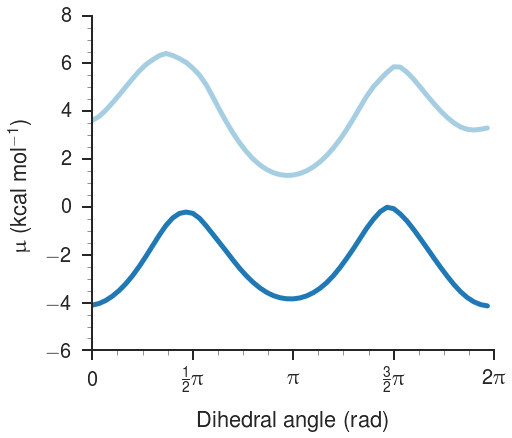

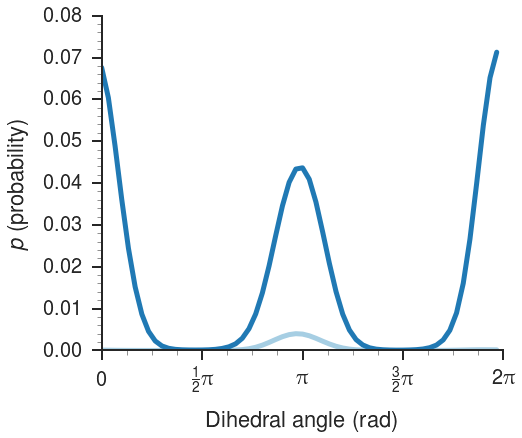

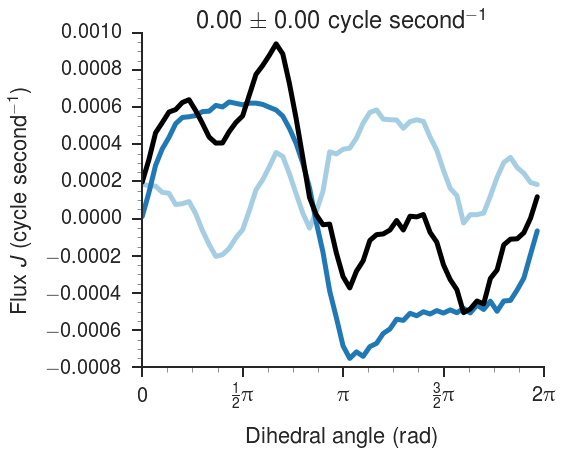

In [110]:
this = simulation(data_source='adk_md_data')
this.name = 'chi3TYR24'
this.catalytic_rate = 0
this.simulate(plot=True)

# Notes

- Sort files by peak amount of intersurface flux on either surface and see if there is something interesting.
- Compare directional and "driven" flux and re-read the Wolynes paper (cf. Bustamante)
- "non-heat-dependent" mechanism
- Plot `p_1 * k_catalysis` vs. [ATP], and compare that to flux vs. [ATP]. Is flux proportional to catalytic rate?

## Does the catalytic rate (i.e., enzyme velocity) saturate with ATP concentration?

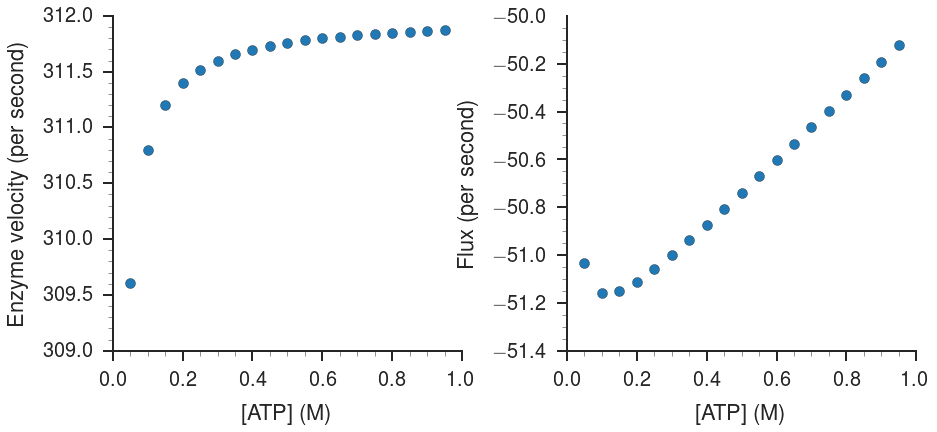

In [147]:
fig = plt.figure(figsize=(12*1.2,6), dpi=300)
from matplotlib.gridspec import GridSpec
gs = GridSpec(1, 2, wspace=0.3)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
cmap = sns.color_palette("Paired", 10)

this = simulation(data_source = 'adk_md_data')
this.name = 'chi3TYR24'
for concentration in np.arange(0.05, 1, 0.05):
    this.cATP = concentration
    this.simulate()
    ax1.scatter(concentration, np.sum(this.ss[this.bins:2*this.bins] * this.catalytic_rate), s=100, c=cmap[1])
    ax2.scatter(concentration, np.mean(this.flux_u + this.flux_b), s=100, c=cmap[1])

ax1.set_xlabel('[ATP] (M)')
ax1.set_ylabel('Enzyme velocity (per second)')
ax2.set_xlabel('[ATP] (M)')
ax2.set_ylabel('Flux (per second)')
aesthetics.paper_plot(fig)

That is quite weird -- I don't think I've seen the flux go down as ATP concentration increases ever before.

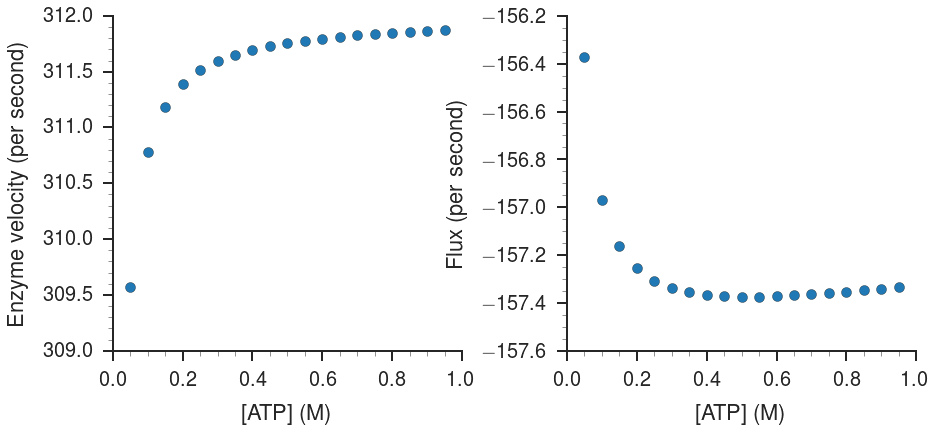

In [149]:
fig = plt.figure(figsize=(12*1.2,6), dpi=300)
from matplotlib.gridspec import GridSpec
gs = GridSpec(1, 2, wspace=0.3)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
cmap = sns.color_palette("Paired", 10)

# For curve fitting...
cATP = []
fluxes = []
velocities = []

this = simulation(data_source = 'adk_md_data')
this.name = 'chi3TYR133'
for concentration in np.arange(0.05, 1, 0.05):
    this.cATP = concentration
    this.simulate()
    ax1.scatter(concentration, np.sum(this.ss[this.bins:2*this.bins] * this.catalytic_rate), s=100, c=cmap[1])
    ax2.scatter(concentration, np.mean(this.flux_u + this.flux_b), s=100, c=cmap[1])
    
    cATP.append(this.cATP)
    fluxes.append(np.mean(this.flux_u + this.flux_b))
    velocities.append(np.sum(this.ss[this.bins:2*this.bins] * this.catalytic_rate))

ax1.set_xlabel('[ATP] (M)')
ax1.set_ylabel('Enzyme velocity (per second)')
ax2.set_xlabel('[ATP] (M)')
ax2.set_ylabel('Flux (per second)')
aesthetics.paper_plot(fig)

This one looks much better behaved.

But let's get *more* data to fit the curves

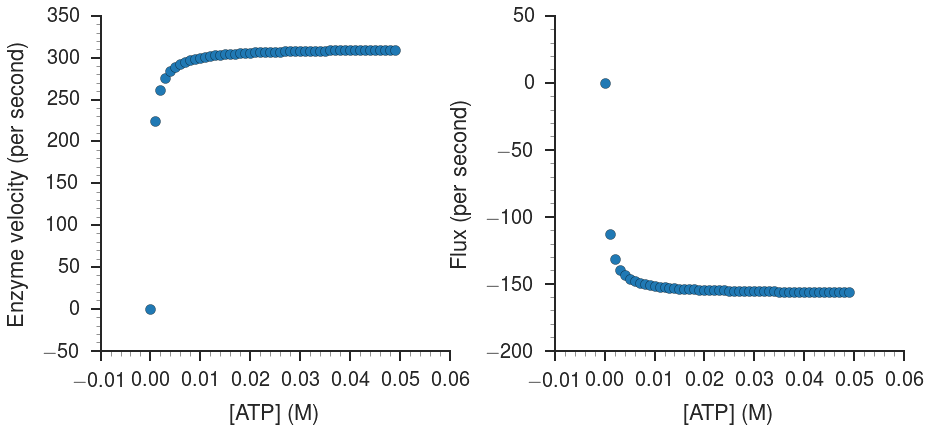

In [186]:
fig = plt.figure(figsize=(12*1.2,6), dpi=300)
from matplotlib.gridspec import GridSpec
gs = GridSpec(1, 2, wspace=0.3)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
cmap = sns.color_palette("Paired", 10)

# For curve fitting...
cATP = []
fluxes = []
velocities = []

this = simulation(data_source = 'adk_md_data')
this.name = 'chi3TYR133'
for concentration in np.arange(0, 0.05, 0.001):
    this.cATP = concentration
    this.simulate()
    ax1.scatter(concentration, np.sum(this.ss[this.bins:2*this.bins] * this.catalytic_rate), s=100, c=cmap[1])
    ax2.scatter(concentration, np.mean(this.flux_u + this.flux_b), s=100, c=cmap[1])
    
    cATP.append(this.cATP)
    fluxes.append(np.mean(this.flux_u + this.flux_b))
    velocities.append(np.sum(this.ss[this.bins:2*this.bins] * this.catalytic_rate))

ax1.set_xlabel('[ATP] (M)')
ax1.set_ylabel('Enzyme velocity (per second)')
ax2.set_xlabel('[ATP] (M)')
ax2.set_ylabel('Flux (per second)')
aesthetics.paper_plot(fig)

In [189]:
def mm(concentration, v_max, k_m):
    # params[0]: maximum velocity
    # params[1]: k_M (Michaelis constant)
    return v_max * concentration / (concentration + k_m)

popt, pcov = sc.optimize.curve_fit(mm, cATP, velocities, p0=[312, 0.01])

In [190]:
v_max = popt[0]
k_m = popt[1]
print('{0:11.9f}, {1:11.9f}'.format(v_max, k_m))

312.000013917, 0.000391937


In [210]:
popt, pcov = sc.optimize.curve_fit(mm, cATP, fluxes, p0=[-200, 0.01])
flux_max = popt[0]
flux_k_m = popt[1]
print('{0:11.9f}, {1:11.9f}'.format(flux_max, flux_k_m))

-157.600833227, 0.000391806


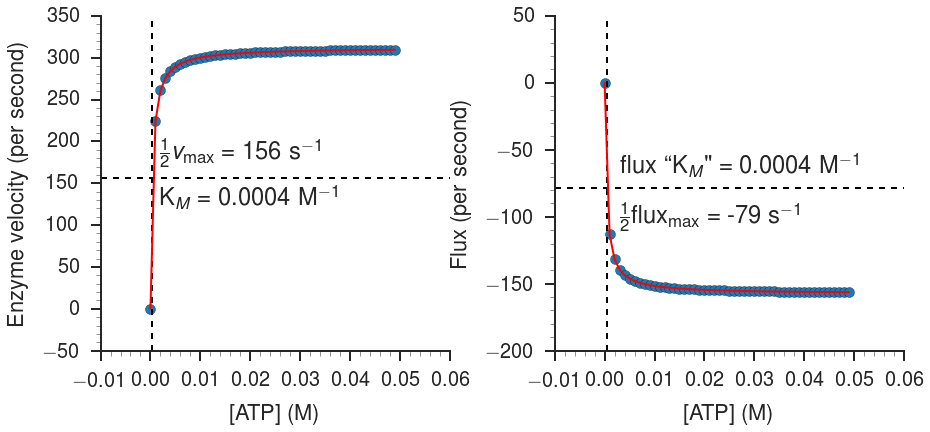

In [221]:
fig = plt.figure(figsize=(12*1.2,6), dpi=300)
from matplotlib.gridspec import GridSpec
gs = GridSpec(1, 2, wspace=0.3)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
cmap = sns.color_palette("Paired", 10)


ax1.scatter(cATP, velocities, s=100, c=cmap[1])
ax2.scatter(cATP, fluxes, s=100, c=cmap[1])

ax1.axvline(x = k_m, ymin = 0, ymax = 0.5 * v_max, c='k', lw=2, ls='--')
ax1.axhline(y = 0.5 * v_max, xmin = 0, c='k', lw=2, ls='--')
ax1.annotate('K$_M$ = {0:0.4f} M$^{{-1}}$'.format(k_m), xy=(0.002, 120))
ax1.annotate(r'$\frac{{1}}{{2}} v_\text{{max}}$ = {0:0.0f} s$^{{-1}}$'.format(0.5*v_max), xy=(0.002, 170))

ax2.axvline(x = flux_k_m, ymin = 0, ymax = -0.5 * flux_max, c='k', lw=2, ls='--')
ax2.axhline(y = 0.5 * flux_max, xmin = 0, c='k', lw=2, ls='--')
ax2.annotate('flux ``K$_M$" = {0:0.4f} M$^{{-1}}$'.format(flux_k_m), xy=(0.003, -70))
ax2.annotate(r'$\frac{{1}}{{2}} \text{{flux}}_\text{{max}}$ = {0:0.0f} s$^{{-1}}$'.format(0.5*flux_max), xy=(0.003, -110))

#ax1.set_ylim([0, 350])
#ax1.set_xlim([0, 0.001])
ax1.plot(cATP, [mm(i, v_max, k_m) for i in cATP], c='r', ls='-', lw=2)
ax2.plot(cATP, [mm(i, flux_max, flux_k_m) for i in cATP], c='r', ls='-', lw=2)

ax1.set_xlabel('[ATP] (M)')
ax1.set_ylabel('Enzyme velocity (per second)')
ax2.set_xlabel('[ATP] (M)')
ax2.set_ylabel('Flux (per second)')
aesthetics.paper_plot(fig)

-0.505123173, -0.003747487


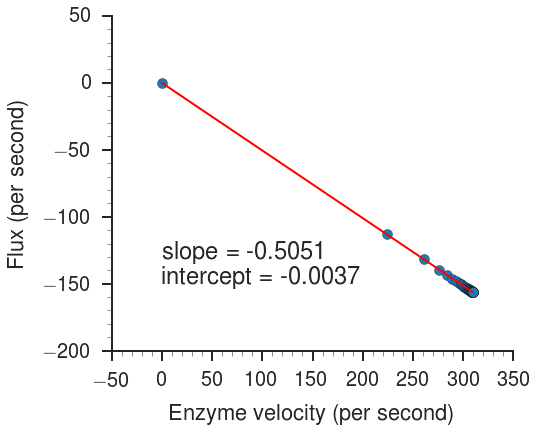

In [230]:
fig = plt.figure(figsize=(6*1.2,6), dpi=300)
from matplotlib.gridspec import GridSpec
gs = GridSpec(1, 1, wspace=0.3)
ax1 = fig.add_subplot(gs[0,0])
cmap = sns.color_palette("Paired", 10)

ax1.scatter(velocities, fluxes, s=100, c=cmap[1])

def line(x, m, b):
    return m * x + b

popt, pcov = sc.optimize.curve_fit(line, velocities, fluxes, p0=[-20, 0])
slope = popt[0]
intercept = popt[1]
print('{0:11.9f}, {1:11.9f}'.format(slope, intercept))
ax1.plot(velocities, [line(i, slope, intercept) for i in velocities], c='r', lw=2)
ax1.annotate('slope = {0:0.4f} \n intercept = {1:0.4f}'.format(slope, intercept), xy=(0.00, -150))


ax1.set_ylabel('Flux (per second)')
ax1.set_xlabel('Enzyme velocity (per second)')
aesthetics.paper_plot(fig)

## Calculate the proportionality between flux and enzyme velocity for all angles.

/home/dslochower/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


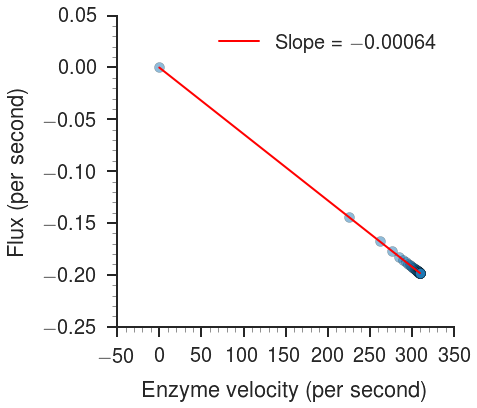

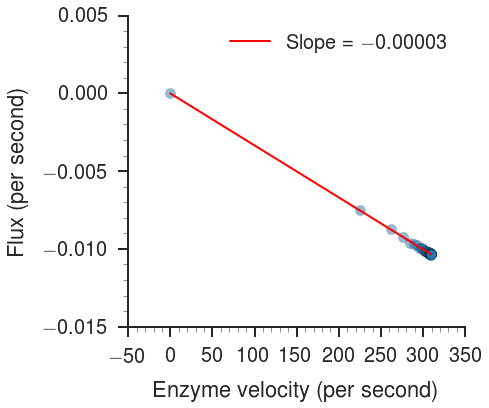

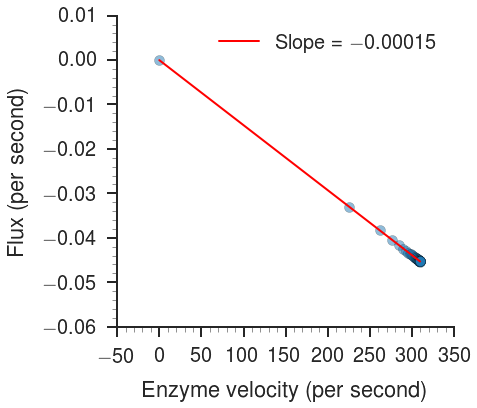

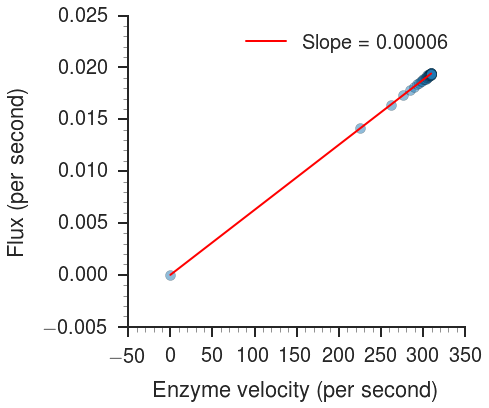

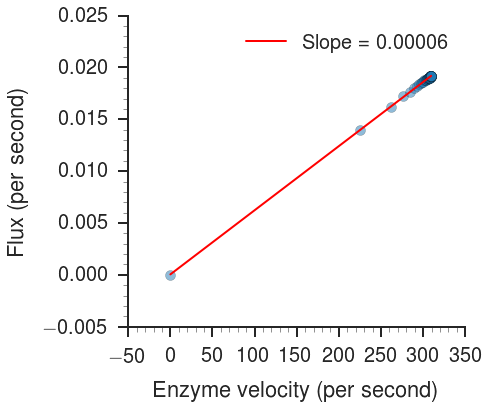

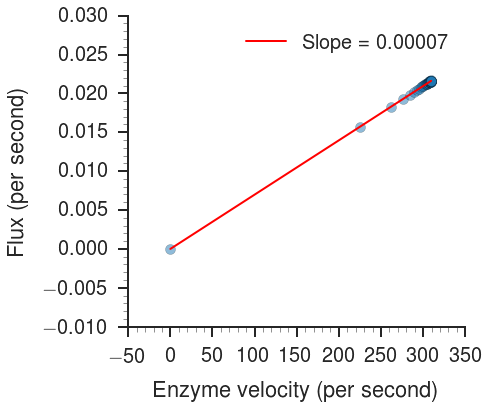

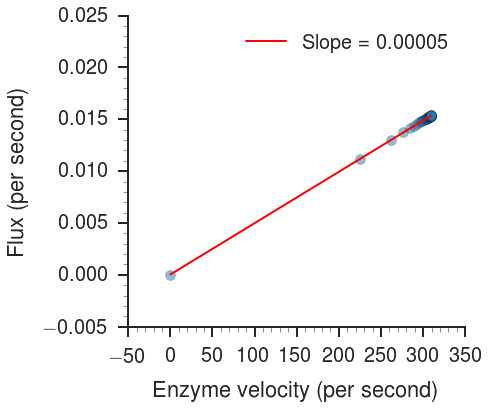

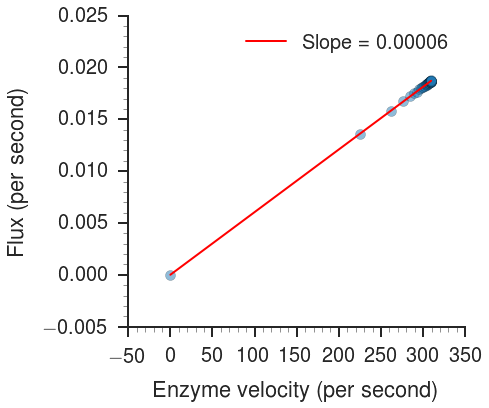

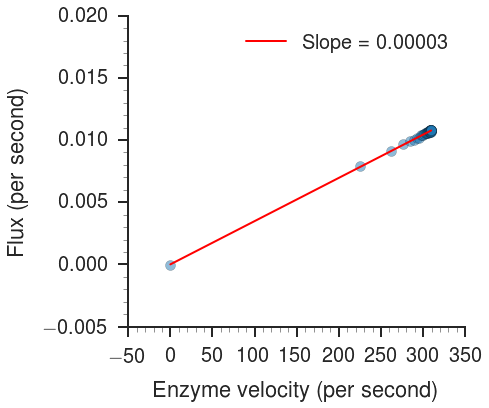

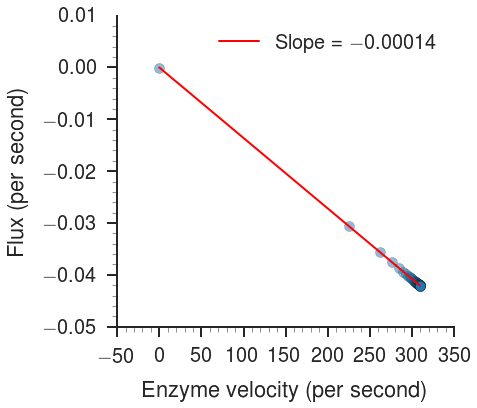

In [245]:
proportionality = pd.DataFrame()
def line(x, m, b):
    return m * x + b



adk_dir = '../../md-data/adenylate-kinase/'
adk_unbound_files = sorted(glob.glob(adk_dir + 'AdKDihedHist_apo-4ake/' + '*'))

for file in range(10):
    name = os.path.splitext(os.path.basename(adk_unbound_files[file]))[0]
    name = re.search('^[^_]*', name).group(0)
    this = simulation(data_source='adk_md_data')
    this.name = name

    concentrations = np.arange(0, 0.05, 0.001)
    fluxes = np.zeros((len(concentrations)))
    velocities = np.zeros((len(concentrations)))
    for concentration in concentrations:
        this.cATP = concentration
        this.simulate()
        fluxes[np.where(concentrations == concentration)[0]] = np.mean(this.flux_u + this.flux_b)
        velocities[np.where(concentrations == concentration)[0]] =  np.sum(this.ss[this.bins:2*this.bins] * this.catalytic_rate)
        
        
    popt, pcov = sc.optimize.curve_fit(line, velocities, fluxes, p0=[-20, 0])
    slope = popt[0]
    intercept = popt[1]
    perr =  np.sqrt(np.diag(pcov))
    fig = plt.figure(figsize=(6*1.2,6), dpi=300)
    gs = GridSpec(1, 1, wspace=0.3)
    ax1 = fig.add_subplot(gs[0,0])
    cmap = sns.color_palette("Paired", 10)
    ax1.scatter(velocities, fluxes, s=100, c=cmap[1], alpha=0.5)
    ax1.plot(velocities, [line(i, slope, intercept) for i in velocities], c='r', lw=2, label='Slope = ${0:0.5f}$'.format(slope))
    ax1.set_ylabel('Flux (per second)')
    ax1.set_xlabel('Enzyme velocity (per second)')
    ax1.legend()
    aesthetics.paper_plot(fig)
    plt.gcf().subplots_adjust(bottom=0.18, left=0.25)
    #from matplotlib import rcParams
    #rcParams.update({'figure.autolayout': True})
    plt.legend(markerscale=0)

    plt.savefig(name+'.png', dpi=300)

    #print('{0:11.9f}, {1:11.9f}'.format(slope, intercept))
    #print(perr)

## Can we tease out a role for driven oar-like cycles with intersurface flux?